In [4]:
#TODO: odpalić też na danych miesięcznych
# from utils import DATA_PATH # utils.py

In [5]:
import pandas as pd
import numpy as np
import glob
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA #here the arima.model instead of arima_model
#from statsmodels.tsa.arima_model import ARIMA #usually I used this version
import statsmodels.api as sm
import math
from datetime import datetime

DATA_PATH = './data'
PREPROCESSED_DATA_PATH = DATA_PATH + '/4_preprocessed_data'
PLOTS = './plots'
ARIMA_PLOTS = PLOTS + '/arima_plots'
ARIMA_MODEL_RESULTS = './models_results/ARIMA'

In [6]:
PREPROCESSED_DATA_PATHS = glob.glob(PREPROCESSED_DATA_PATH + "/*.csv")
USE_LOG = True
"""
https://predictivehacks.com/time-series-decomposition/
Our data here are aggregated by days. 
The period we want to analyze is by year so that’s why we set the period to 365.
"""
PERIOD = 365 
P_VALUE_PERCENT = '1%' #['1%', '5%', '10%']
P_VALUE = float(P_VALUE_PERCENT.strip('%')) / 100.0
"""
'c' : constant only
'ct' : constant and trend.
'ctt' : constant, and linear and quadratic trend
'n' : no constant, no trend
"""
REGRESSION_TYPE_FOR_DF_TEST = 'c' #['c', 'ct', 'ctt', 'n']
#najczęściej występuje wersja ze stałą, czyli 'c'
AUTOLAG_FOR_DF_TEST = 'AIC' #['AIC', 'BIC'], może być zawsze AIC

LJUNGBOX_BOXPIERCE_LAGS = 24 #dla szeregu niesezonowego najczęściej ilosc lagow=24

PERIODS_TO_FORECAST = [6, 10, 30]

#p and q ranges
P_RANGE = range(0, 8) #range(0, 10)
Q_RANGE = range(0, 8) #range(0, 10)

#columns to create table with MAE for experiments
COLUMN_NAMES = ['Company', 'ARIMA', 'p', 'd', 'q', 'fc_period', 'MAE']

In [7]:
def decompose_time_series(df, company, period):
    """
    sm.tsa.seasonal_decompose returns a DecomposeResult. 
    This has attributes observed, trend, seasonal and resid, which are pandas series. 
    You may plot each of them using the pandas plot functionality.
    """
    df.set_index('timestamp', inplace=True)
    df.index=pd.to_datetime(df.index)
    result = seasonal_decompose(df['avg_price'], period=period)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14,22), dpi=65)
    ax1.plot(result.observed, color='blue', linewidth=1)
    ax1.set_title('{0} original time series'.format(company))
    ax2.plot(result.trend, color='red', linewidth=1)
    ax2.set_title('Trend')
    ax3.plot(result.seasonal, color='red', linewidth=1)
    ax3.set_title('Seasonality')
    ax4.plot(result.resid, color='red', linewidth=1)
    ax4.set_title('Residuals')
    plt.xlabel('Date')
    plt.savefig(ARIMA_PLOTS + '/{0}_decomposition.png'.format(company));
    plt.show()
    plt.close(fig)

In [8]:
def visualize_after_log(df):
    fig = plt.figure(figsize=(14,7), dpi=100)
    plt.plot(df['timestamp'], df['avg_price'], color='purple', linewidth=2, linestyle='solid')
    plt.title("{0} after logarithm".format(company))
    plt.xlabel('Date')
    plt.ylabel('Daily average log price values')
    plt.legend(['{0}'.format(company)]) 
    plt.savefig(ARIMA_PLOTS + '/{0}_after_log.png'.format(company));
    plt.show()
    plt.close(fig)

In [9]:
def perform_df_test(timeseries, reg, autol, pval):
    """
    I choose AIC as autolag (more often used than BIC). 
    I choose regression type (reg) as 'c' : constant only (default). 
    """
    dftest = adfuller(timeseries, regression = reg, autolag = autol)
    #p_value = dftest[1]
    test_statistic = dftest[0]
    critical_value = dftest[4][pval]
    
    return test_statistic, critical_value

In [10]:
def perform_first_difference(df, number_of_first_diff):
    if number_of_first_diff == 1:
        df['diff_price'] = df.avg_price.diff()
        df.drop('avg_price', axis=1, inplace=True)
    else:
        df.diff_price = df.diff_price.diff()
    df = df.iloc[1: , :]
    df = df.reset_index(drop=True)
    
    fig = plt.figure(figsize=(14,7), dpi=100)
    plt.plot(df['timestamp'], df['diff_price'], color='green', linewidth=1, linestyle='solid')
    plt.title("{0} after {1} first difference".format(company, number_of_first_diff))
    plt.xlabel('Date')
    plt.ylabel('Daily average price values after log and first diff')
    plt.legend(['{0}'.format(company)]) 
    plt.savefig(ARIMA_PLOTS + '/{0}_after_{1}_first_difference.png'.format(company, number_of_first_diff));
    plt.show()
    plt.close(fig)
    
    return df

In [11]:
def perform_ljungbox_boxpierce(df_price, p, d, q, lags):
    """
    Performs Ljung-Box and Box-Pierce tests. Check the residuals autocorrelations. 
    https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
    Remember, that p, d, q values HAVE TO BE INTEGERS!!
    """
    res = sm.tsa.ARIMA( df_price, (p, d, q) ).fit(disp=-1)
    lb_bp_results = sm.stats.acorr_ljungbox(res.resid, lags=[lags], return_df=True, boxpierce = True)
    lb_p_value = lb_bp_results['lb_pvalue'].values[0]
    bp_p_value = lb_bp_results['bp_pvalue'].values[0]
    residuals = res.resid
    
    return lb_p_value, bp_p_value, residuals

In [12]:
def create_acf_pacf_charts(series, lags, datatype):
    """
    Remember to ommit first tab ("wypustka"), because it's the correlation of the variable with itself. 
    It can be ommited by using parameter zero=False. 
    Documentation about plot_acf: https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
    zero: bool, optional
    Flag indicating whether to include the 0-lag autocorrelation. Default is True.
    """
    #SET TEMPORARY PLOT STYLE
    plt.style.use('classic')
    plt.rcParams['figure.facecolor'] = 'white'
    #ACF
    fig = plt.figure(figsize=(12,9), dpi=90)
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, lags=LJUNGBOX_BOXPIERCE_LAGS, zero=False, ax=ax1) #residuals
    plt.ylabel('Value')
    #PACF
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=LJUNGBOX_BOXPIERCE_LAGS, zero=False, method="ywm", ax=ax2) #residuals
    plt.ylabel('Value')
    plt.xlabel('Number of tabs')
    plt.savefig(ARIMA_PLOTS + '/{0}_{1}_plot_ACF_and_PACF.png'.format(company, datatype)); #, bbox_inches=0
    plt.show()
    plt.close(fig)
    
    #BACK TO DEFINED STYLE
    plt.style.use('fivethirtyeight')
    plt.style.use('seaborn-bright')

In [13]:
def create_prediction_plot(df, train, test, fc_series, lower_series, upper_series, period, train_timestamp, test_timestamp):
    #prepare xticks for plot
    #list_x_ticks = []
    #list_timestamps_x_ticks = []
    #final_year = df.timestamp[len(df)-1].year
    #for xtick in range(0, len(df) + round(len(df)/7), round(len(df)/7)):
    #    list_x_ticks.append(xtick)
    #    if xtick > len(df):
    #        list_timestamps_x_ticks.append(final_year + 2)
    #    else:
    #        list_timestamps_x_ticks.append(df.timestamp[xtick].year)

    #prepare yticks for plot
    list_y_ticks = []
    display(df.avg_price.min(), df.avg_price.max())
    min_val = df.avg_price.min()
    max_val = df.avg_price.max()
    step = (max_val - min_val) / 7
    print("step:", step)
    print('\n')
    for ytick in np.arange(min_val, max_val+step, step):
        print(ytick)
        list_y_ticks.append(round(ytick, 2))
    display(list_y_ticks)

    #prepare y_exp_ticks for plot
    list_exp_y_ticks = []
    display(df.avg_price.min(), df.avg_price.max())
    display(np.exp(df.avg_price.min()), np.exp(df.avg_price.max()))
    min_val = np.exp(df.avg_price.min())
    max_val = np.exp(df.avg_price.max())
    step = (max_val - min_val) / 7
    print("step:", step)
    print('\n')
    for ytick in np.arange(min_val, max_val+step, step):
        print(ytick)
        list_exp_y_ticks.append(round(ytick, 2))
    display(list_exp_y_ticks)

    # Plot
    #SET TEMPORARY PLOT STYLE
    plt.style.use('classic')
    plt.rcParams['figure.facecolor'] = 'white'

    fig = plt.figure(figsize=(12,7), dpi=90)

    plt.plot(train_timestamp, train, label='training', linewidth=1) #train.index
    plt.plot(test_timestamp, test, label='actual', linewidth=1) #test.index
    plt.plot(test_timestamp, fc_series, label='forecast', linewidth=1) #fc_series.index

    plt.fill_between(test_timestamp, lower_series, upper_series, color='k', alpha=.15) #lower_series.index, 

    plt.title(f'Forecast vs Actuals for forecast period = {period}')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlabel('Time [years]')
    plt.ylabel('Real value [\$]')
    #plt.xticks(list_x_ticks, list_timestamps_x_ticks, rotation = 45)
    plt.yticks(list_y_ticks, list_exp_y_ticks, color="red")
    plt.savefig(ARIMA_PLOTS + '/{0}_ARIMA_prediction_plot.png'.format(company))
    plt.show()

    #now zoom in
    plt.close(fig)
    #################################################

In [14]:
def create_zoomed_prediction_plot(df, test, fc_series, lower_series, upper_series, period, test_timestamp):
    #prepare yticks
    minimum_value = lower_series.values.min()
    maximum_value = upper_series.values.max()
    print("min value",minimum_value, "max value", maximum_value)

    #prepare yticks for plot
    list_y_ticks = []
    #display(minimum_value, maximum_value)
    min_val = round(minimum_value, 2)
    max_val = round(maximum_value, 2)
    print("min value",min_val, "max value", max_val)
    step = round((max_val - min_val) / 7, 2)
    print("step:", step)
    print('\n')
    for ytick in np.arange(min_val, max_val+step, step):
        #print(ytick)
        list_y_ticks.append(round(ytick, 2))
    display("final y list", list_y_ticks)

    #prepare y_exp_ticks for plot
    list_exp_y_ticks = []
    print("min value",minimum_value, "max value", maximum_value)
    min_val = round(np.exp(minimum_value), 2)
    max_val = round(np.exp(maximum_value), 2)
    print("min exp value",min_val, "max exp value", max_val)
    step = round((max_val - min_val) / 6, 2)
    print("step:", step)
    print('\n')
    for ytick in np.arange(min_val, max_val, step):
        #print(ytick)
        list_exp_y_ticks.append(round(ytick, 2))
    display("final y exp list", list_exp_y_ticks)
    
    #PLOT
    fig = plt.figure(figsize=(12,7), dpi=90)
    ax3 = plt.subplot(111)
    plt.plot(test_timestamp, test, label='actual', linewidth=2) #test.index
    plt.plot(test_timestamp, fc_series, label='forecast', linewidth=2)
    plt.fill_between(test_timestamp, lower_series, upper_series, color='k', alpha=.15)

    #ax3.margins(x=-0.49, y=-0.25)
    #ax3.xaxis.zoom(4)
    plt.title(f'Forecast vs Actuals for forecast period = {period}')
    plt.legend(loc='upper left', fontsize=8)
    plt.xticks(rotation=45)
    #plt.xticks(list_x_ticks, list_timestamps_x_ticks, rotation = 45)
    plt.yticks(list_y_ticks, list_exp_y_ticks, color="red")
    plt.ylabel('Real value [\$]')
    plt.xlabel('Date')
    #plt.xlim(2019, 2021)
    plt.tight_layout() #in order not to cut bottom part of plot in saved one
    plt.savefig(ARIMA_PLOTS + '/{0}_ARIMA_zoomed_prediction_plot.png'.format(company))
    plt.show()
    plt.close(fig)

ACN


,timestamp,avg_price
0,2008-01-02,36.097190
1,2008-01-03,35.620970
2,2008-01-04,34.970941
3,2008-01-05,34.680679
4,2008-01-06,34.390417
...,...,...
5009,2021-10-15,340.964570
5010,2021-10-16,341.661594
5011,2021-10-17,342.358618
5012,2021-10-18,343.055643


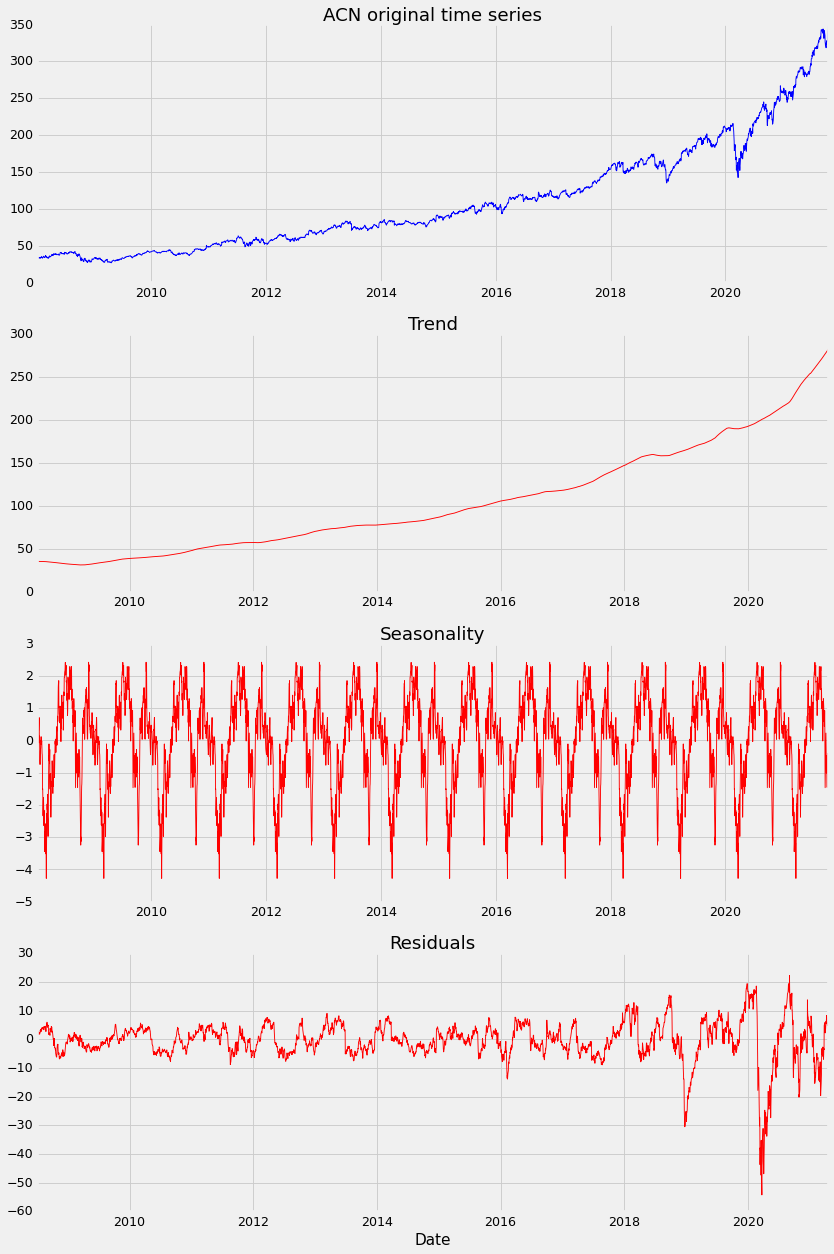

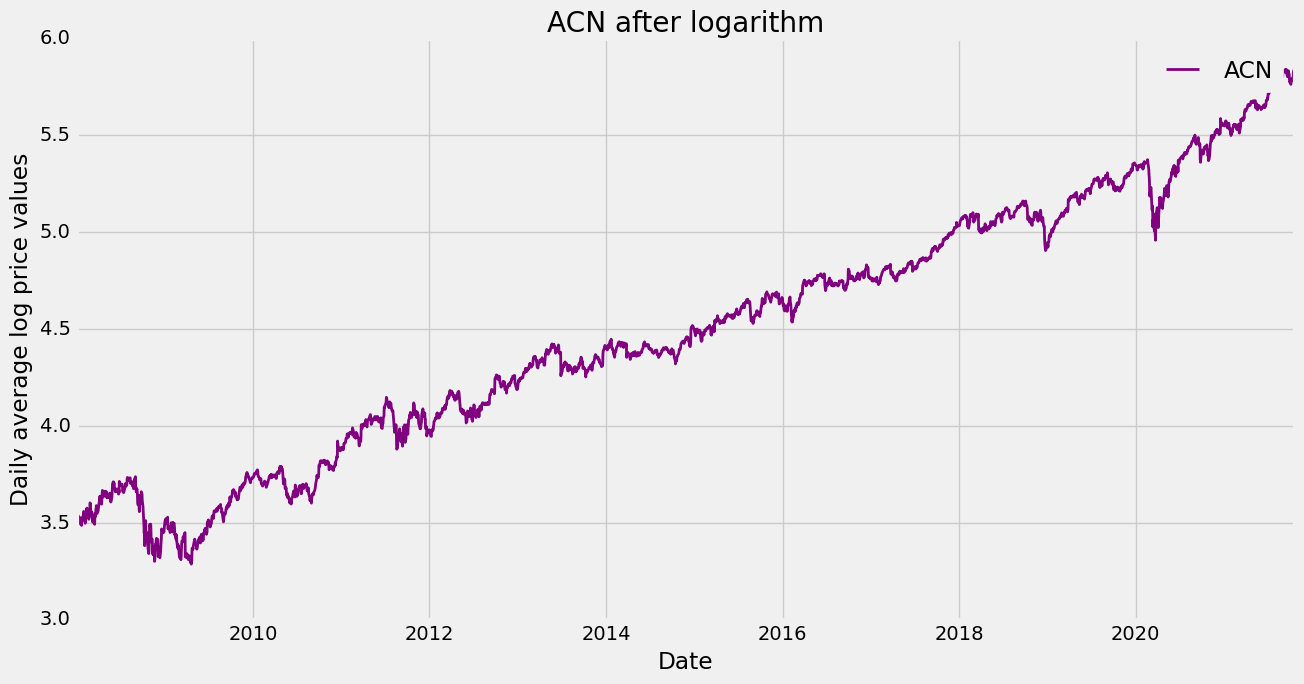

,timestamp,avg_price
0,2008-01-02,3.586215
1,2008-01-03,3.572934
2,2008-01-04,3.554517
3,2008-01-05,3.546183
4,2008-01-06,3.537778
...,...,...
5009,2021-10-15,5.831779
5010,2021-10-16,5.833821
5011,2021-10-17,5.835859
5012,2021-10-18,5.837893


0.27707836397339175 -3.4316572241792462


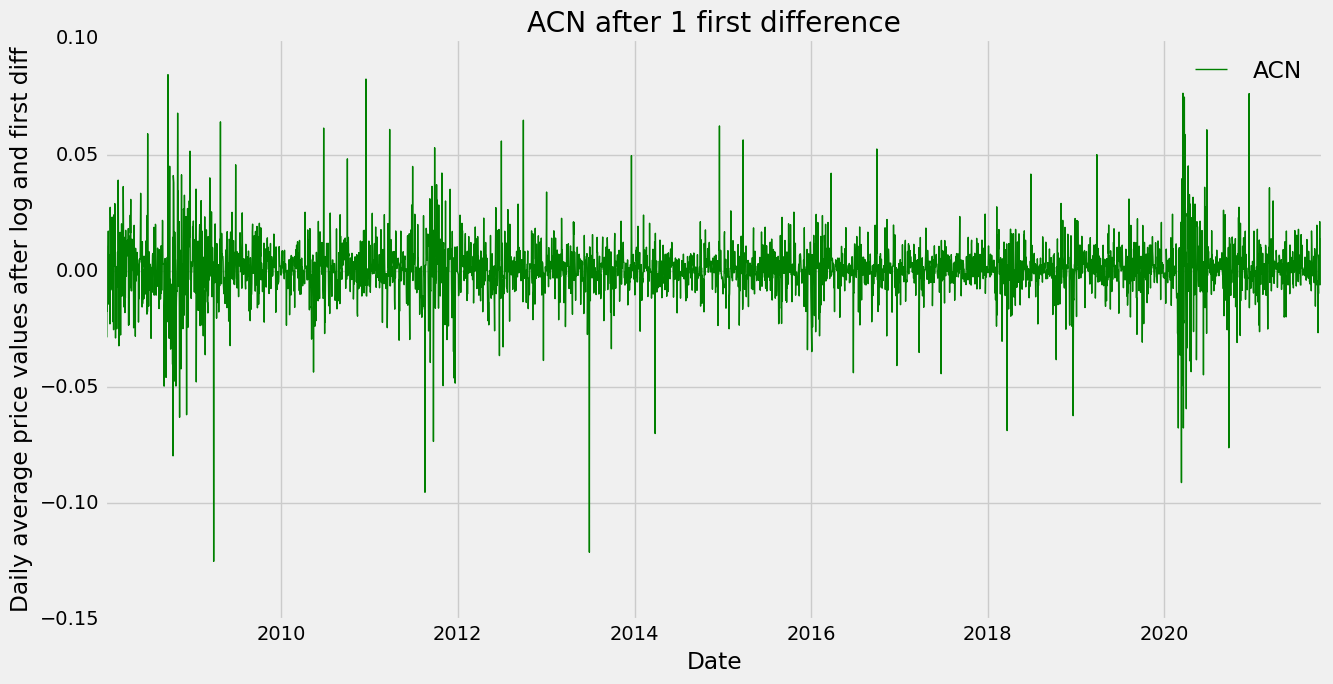

Number of first diff = 1
-26.755893250629892 -3.4316572241792462
Number of performed first diff = 1


'Original dataframe'

,timestamp,avg_price
0,2008-01-02,3.586215
1,2008-01-03,3.572934
2,2008-01-04,3.554517
3,2008-01-05,3.546183
4,2008-01-06,3.537778
...,...,...
5009,2021-10-15,5.831779
5010,2021-10-16,5.833821
5011,2021-10-17,5.835859
5012,2021-10-18,5.837893


'First differenced dataframe'

,timestamp,diff_price
0,2008-01-03,-0.013281
1,2008-01-04,-0.018417
2,2008-01-05,-0.008335
3,2008-01-06,-0.008405
4,2008-01-07,-0.008476
...,...,...
5008,2021-10-15,0.010468
5009,2021-10-16,0.002042
5010,2021-10-17,0.002038
5011,2021-10-18,0.002034


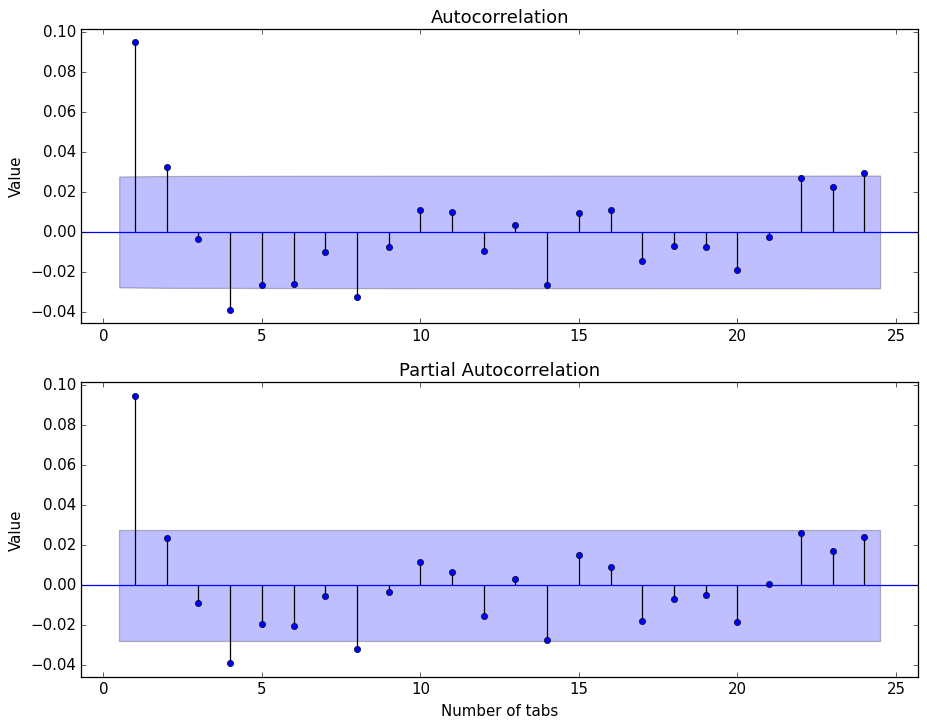

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization fail

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

[-27855.468132599308, -30808.882178581065, -30844.391899085498, -30841.23193698642, -30792.3700992601, -30836.78115391089, -30826.871125928992, -30824.0392393111, -29078.302230927362, -30852.00659131224, -30804.663984919993, -30834.049884688247, -30834.62721685546, -30828.70459929995, -30816.670626127816, -30790.74860902344, -29527.149658924012, -30853.575444143346, -30847.28088496032, -30795.821067119665, -30829.043894443406, -30824.401746924934, -30808.944705915117, -30812.479160248502, -29733.444601566116, -30842.221576911692, -30842.812039974247, -30831.40405420737, -30801.057205317888, -30820.65792512221, -30802.0642028929, -30800.489316865605, -29903.409741242416, -30725.161021522013, -30813.80772209651, -30832.05627662179, -30804.91330029252, -30767.049709820374, -30786.883098220198, -30800.987272597802, -30023.00782507495, -30804.49287017208, -30830.295055163177, -30722.07497109104, -30807.02400372524, -30754.807218389396, -30810.70675490041, -30778.661324594053, -30130.5158046

,ARIMA,p,d,q,AIC,BIC
0,"ARIMA(0,1,0)",0,1,0,-27855.468133,-27848.948742
1,"ARIMA(0,1,1)",0,1,1,-30808.882179,-30795.843796
2,"ARIMA(0,1,2)",0,1,2,-30844.391899,-30824.834924
3,"ARIMA(0,1,3)",0,1,3,-30841.231937,-30815.156769
4,"ARIMA(0,1,4)",0,1,4,-30792.370099,-30759.777138
...,...,...,...,...,...,...
59,"ARIMA(7,1,3)",7,1,3,-30545.969442,-30474.269323
60,"ARIMA(7,1,4)",7,1,4,-30769.551279,-30691.332966
61,"ARIMA(7,1,5)",7,1,5,-30753.783944,-30669.047439
62,"ARIMA(7,1,6)",7,1,6,-30766.358191,-30675.103493


Best ARIMA according to AIC criterium:
ARIMA    ARIMA(2,1,1)
p                   2
d                   1
q                   1
AIC          -30853.6
BIC          -30827.5
Name: 17, dtype: object

Best ARIMA according to BIC criterium:
ARIMA    ARIMA(1,1,1)
p                   1
d                   1
q                   1
AIC            -30852
BIC          -30832.4
Name: 9, dtype: object


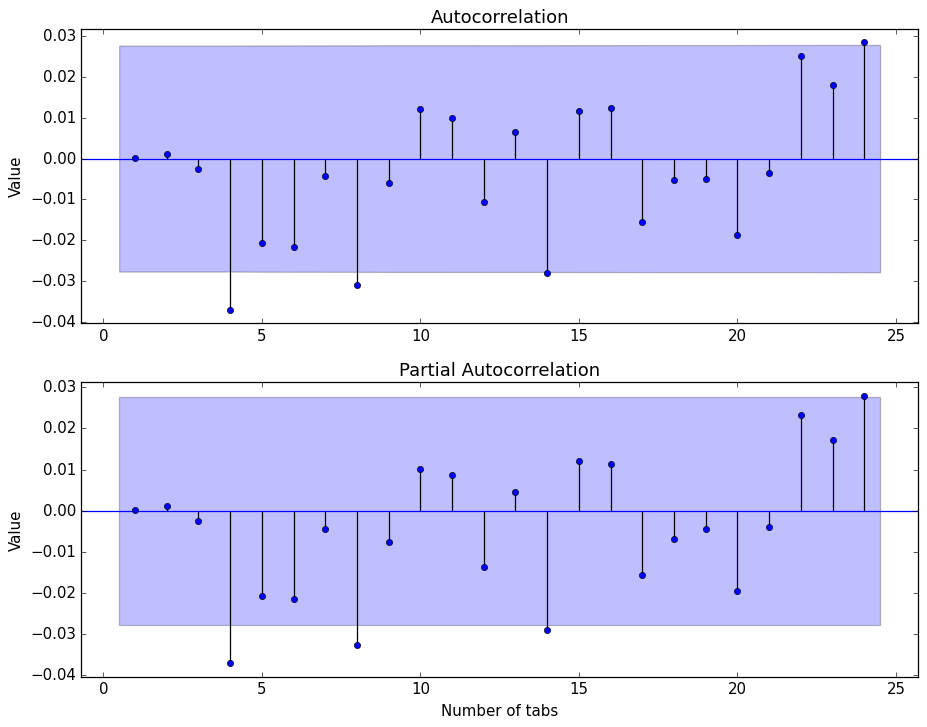

                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 5008
Model:                 ARIMA(2, 1, 1)   Log Likelihood               15424.979
Date:                Thu, 04 Nov 2021   AIC                         -30841.958
Time:                        19:42:58   BIC                         -30815.883
Sample:                             0   HQIC                        -30832.820
                               - 5008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2154      0.468     -0.460      0.645      -1.133       0.702
ar.L2          0.0542      0.042      1.281      0.200      -0.029       0.137
ma.L1          0.3084      0.468      0.659      0.5

3.285925749214768

5.856061292856436

step: 0.36716222052023834


3.285925749214768
3.6530879697350067
4.020250190255245
4.387412410775484
4.754574631295722
5.12173685181596
5.488899072336199
5.856061292856438


[3.29, 3.65, 4.02, 4.39, 4.75, 5.12, 5.49, 5.86]

3.285925749214768

5.856061292856436

26.733721584630885

349.34546122466844

step: 46.08739137714822


26.733721584630885
72.82111296177911
118.90850433892733
164.99589571607555
211.08328709322376
257.17067847037197
303.25806984752023
349.34546122466844


[26.73, 72.82, 118.91, 165.0, 211.08, 257.17, 303.26, 349.35]

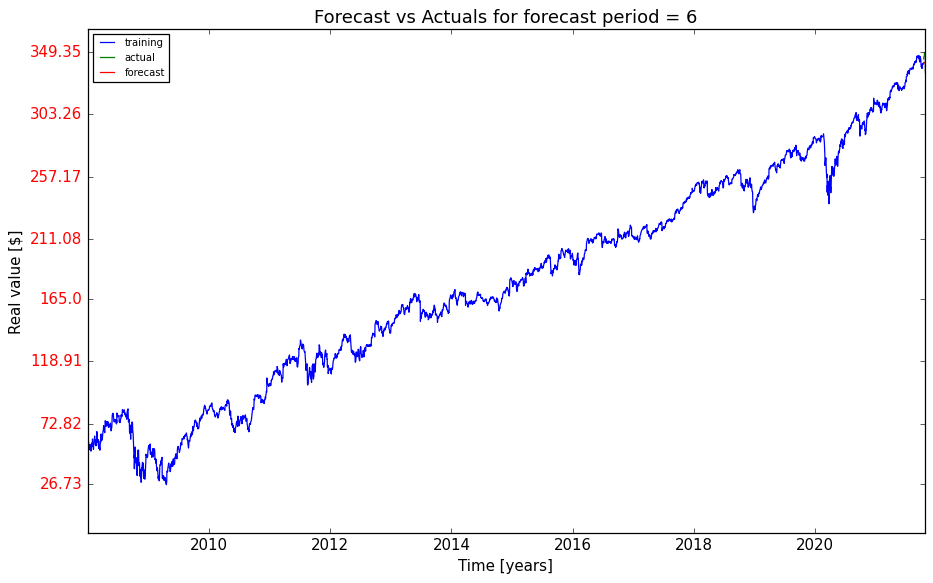

min value 5.7383477218994114 max value 5.855792000115771
min value 5.74 max value 5.86
step: 0.02




'final y list'

[5.74, 5.76, 5.78, 5.8, 5.82, 5.84, 5.86]

min value 5.7383477218994114 max value 5.855792000115771
min exp value 310.55 max exp value 349.25
step: 6.45




'final y exp list'

[310.55, 317.0, 323.45, 329.9, 336.35, 342.8]

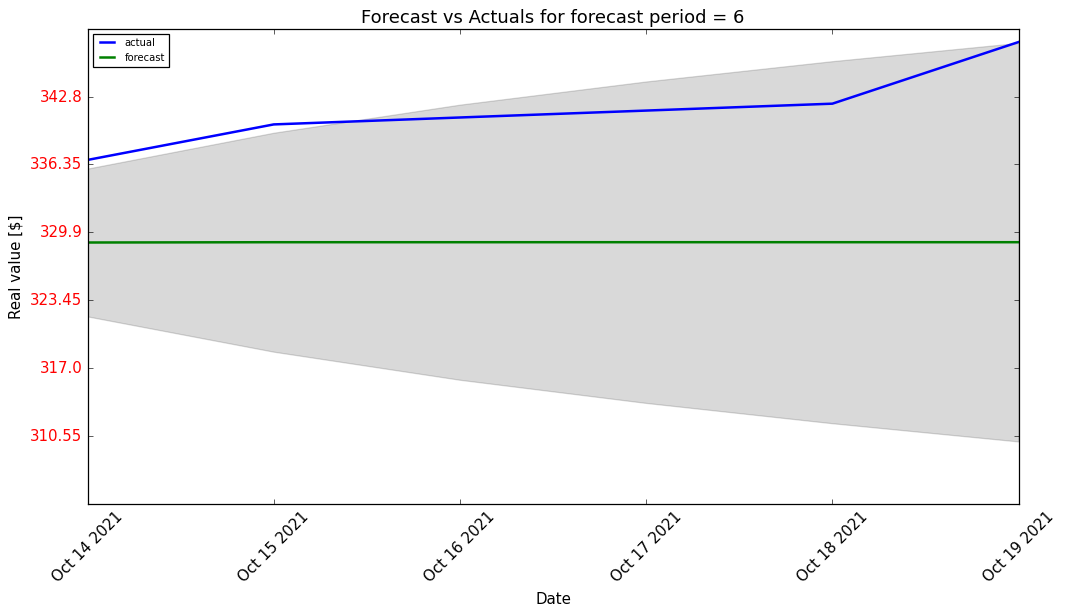

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 5004
Model:                 ARIMA(2, 1, 1)   Log Likelihood               15410.729
Date:                Thu, 04 Nov 2021   AIC                         -30813.459
Time:                        19:43:01   BIC                         -30787.387
Sample:                             0   HQIC                        -30804.321
                               - 5004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2167      0.467     -0.464      0.643      -1.133       0.699
ar.L2          0.0543    

3.285925749214768

5.856061292856436

step: 0.36716222052023834


3.285925749214768
3.6530879697350067
4.020250190255245
4.387412410775484
4.754574631295722
5.12173685181596
5.488899072336199
5.856061292856438


[3.29, 3.65, 4.02, 4.39, 4.75, 5.12, 5.49, 5.86]

3.285925749214768

5.856061292856436

26.733721584630885

349.34546122466844

step: 46.08739137714822


26.733721584630885
72.82111296177911
118.90850433892733
164.99589571607555
211.08328709322376
257.17067847037197
303.25806984752023
349.34546122466844


[26.73, 72.82, 118.91, 165.0, 211.08, 257.17, 303.26, 349.35]

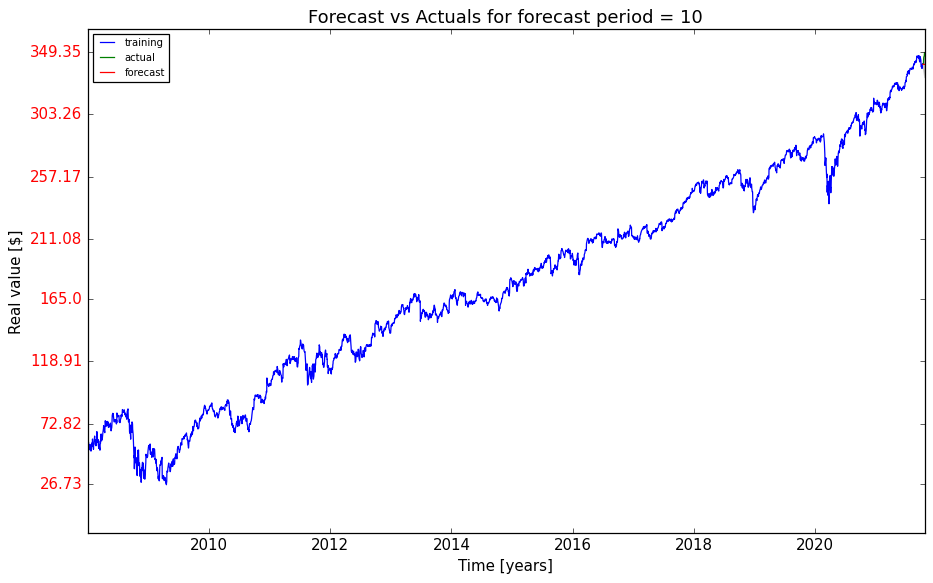

min value 5.711457093749628 max value 5.864572785151765
min value 5.71 max value 5.86
step: 0.02




'final y list'

[5.71, 5.73, 5.75, 5.77, 5.79, 5.81, 5.83, 5.85, 5.87]

min value 5.711457093749628 max value 5.864572785151765
min exp value 302.31 max exp value 352.33
step: 8.34




'final y exp list'

[302.31, 310.65, 318.99, 327.33, 335.67, 344.01]

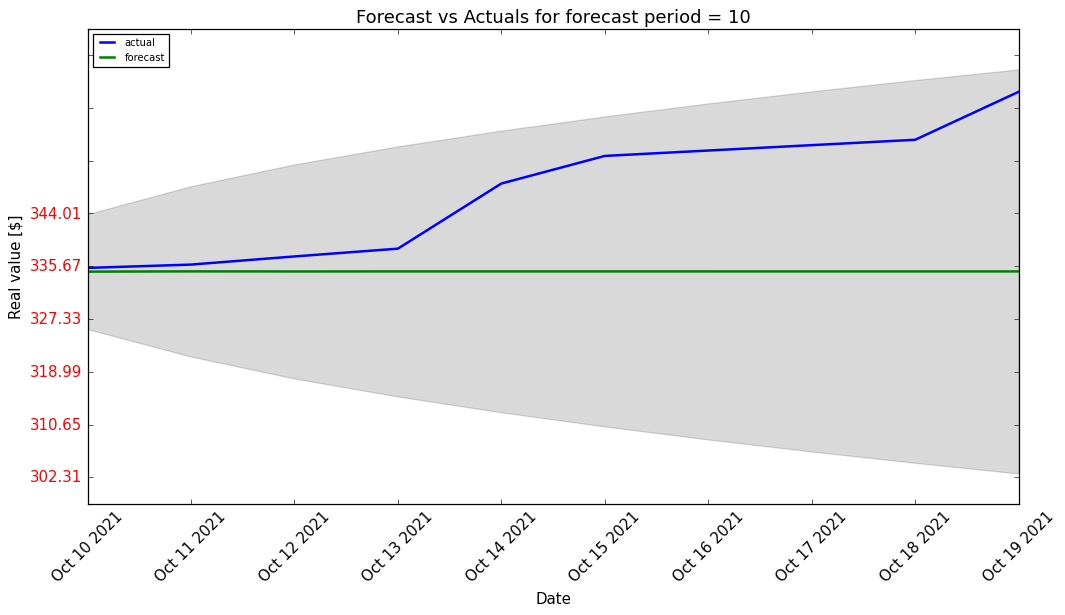

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1     ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 4984
Model:                 ARIMA(2, 1, 1)   Log Likelihood               15348.256
Date:                Thu, 04 Nov 2021   AIC                         -30688.512
Time:                        19:43:04   BIC                         -30662.457
Sample:                             0   HQIC                        -30679.379
                               - 4984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1921      0.509     -0.377      0.

3.285925749214768

5.856061292856436

step: 0.36716222052023834


3.285925749214768
3.6530879697350067
4.020250190255245
4.387412410775484
4.754574631295722
5.12173685181596
5.488899072336199
5.856061292856438


[3.29, 3.65, 4.02, 4.39, 4.75, 5.12, 5.49, 5.86]

3.285925749214768

5.856061292856436

26.733721584630885

349.34546122466844

step: 46.08739137714822


26.733721584630885
72.82111296177911
118.90850433892733
164.99589571607555
211.08328709322376
257.17067847037197
303.25806984752023
349.34546122466844


[26.73, 72.82, 118.91, 165.0, 211.08, 257.17, 303.26, 349.35]

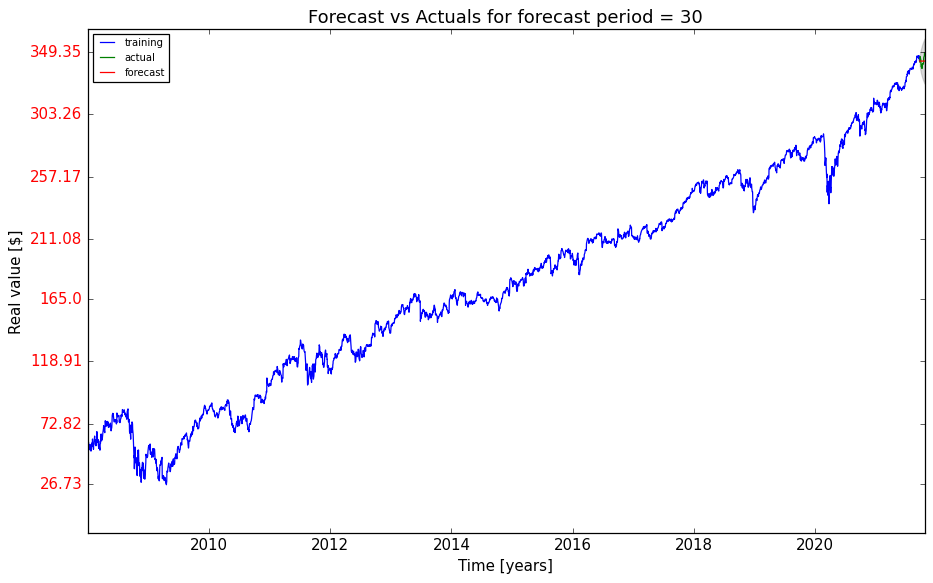

min value 5.673755469606034 max value 5.941475853029409
min value 5.67 max value 5.94
step: 0.04




'final y list'

[5.67, 5.71, 5.75, 5.79, 5.83, 5.87, 5.91, 5.95]

min value 5.673755469606034 max value 5.941475853029409
min exp value 291.13 max exp value 380.5
step: 14.9




'final y exp list'

[291.13, 306.03, 320.93, 335.83, 350.73, 365.63]

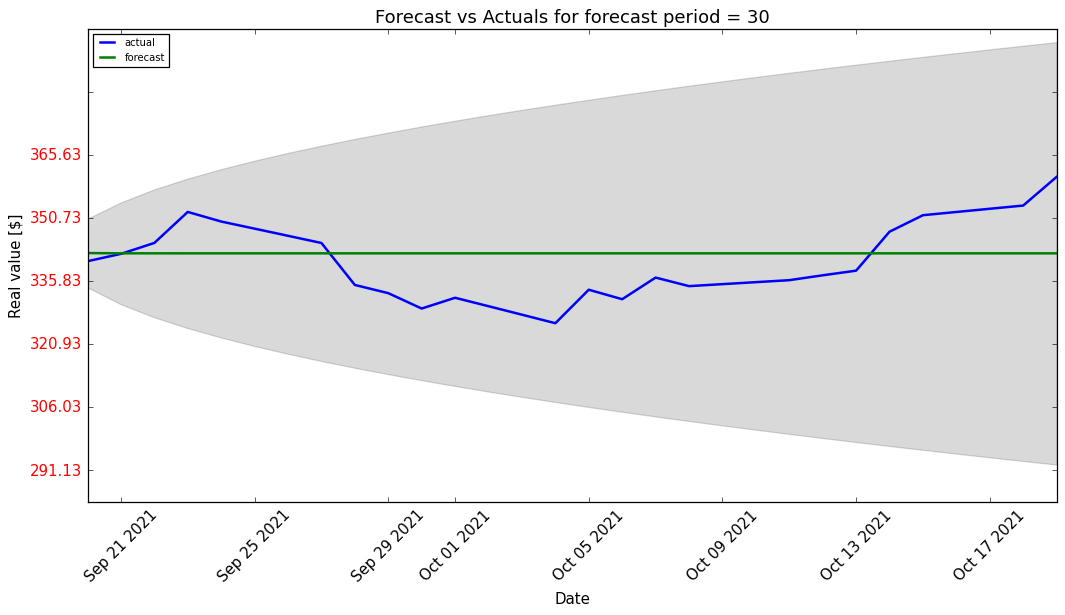

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1     ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2     ACN  ARIMA(2,1,1)  2  1  1        30  0.021863


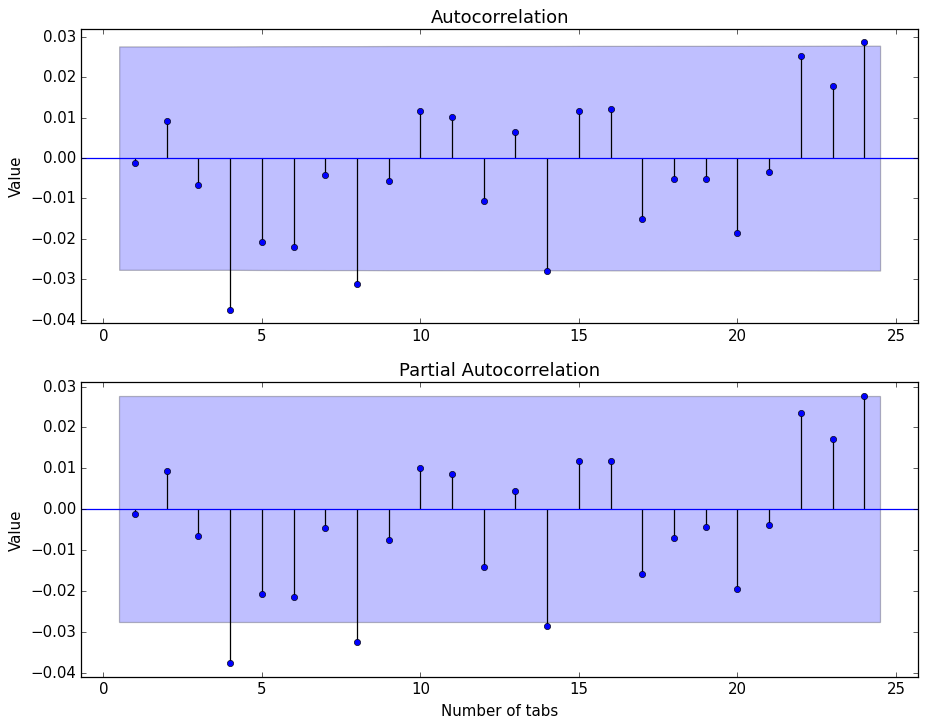

                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 5008
Model:                 ARIMA(1, 1, 1)   Log Likelihood               15424.747
Date:                Thu, 04 Nov 2021   AIC                         -30843.495
Time:                        19:43:08   BIC                         -30823.939
Sample:                             0   HQIC                        -30836.641
                               - 5008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3165      0.093      3.402      0.001       0.134       0.499
ma.L1         -0.2234      0.094     -2.382      0.017      -0.407      -0.040
sigma2         0.0001   7.95e-07    155.256      0.0

3.285925749214768

5.856061292856436

step: 0.36716222052023834


3.285925749214768
3.6530879697350067
4.020250190255245
4.387412410775484
4.754574631295722
5.12173685181596
5.488899072336199
5.856061292856438


[3.29, 3.65, 4.02, 4.39, 4.75, 5.12, 5.49, 5.86]

3.285925749214768

5.856061292856436

26.733721584630885

349.34546122466844

step: 46.08739137714822


26.733721584630885
72.82111296177911
118.90850433892733
164.99589571607555
211.08328709322376
257.17067847037197
303.25806984752023
349.34546122466844


[26.73, 72.82, 118.91, 165.0, 211.08, 257.17, 303.26, 349.35]

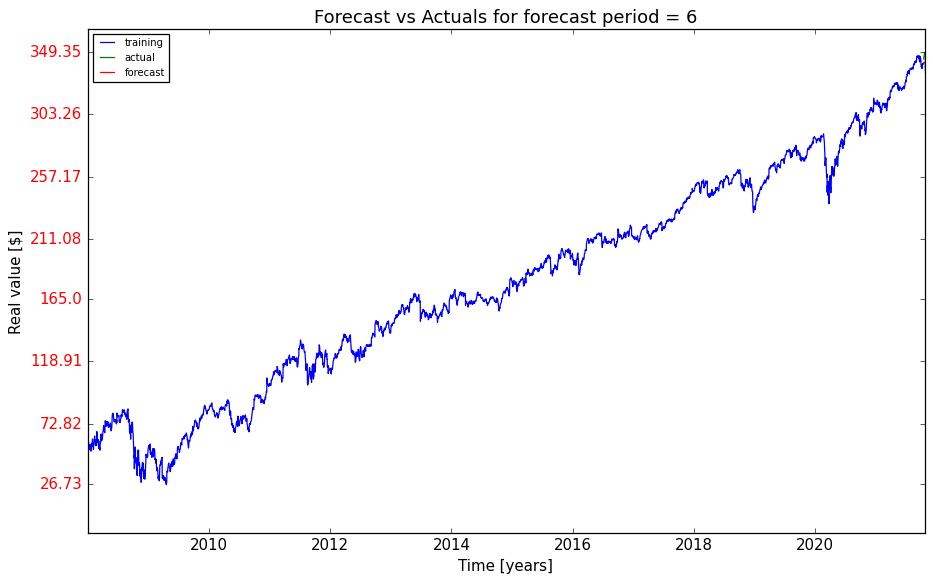

min value 5.738241789950697 max value 5.8560431956684695
min value 5.74 max value 5.86
step: 0.02




'final y list'

[5.74, 5.76, 5.78, 5.8, 5.82, 5.84, 5.86]

min value 5.738241789950697 max value 5.8560431956684695
min exp value 310.52 max exp value 349.34
step: 6.47




'final y exp list'

[310.52, 316.99, 323.46, 329.93, 336.4, 342.87]

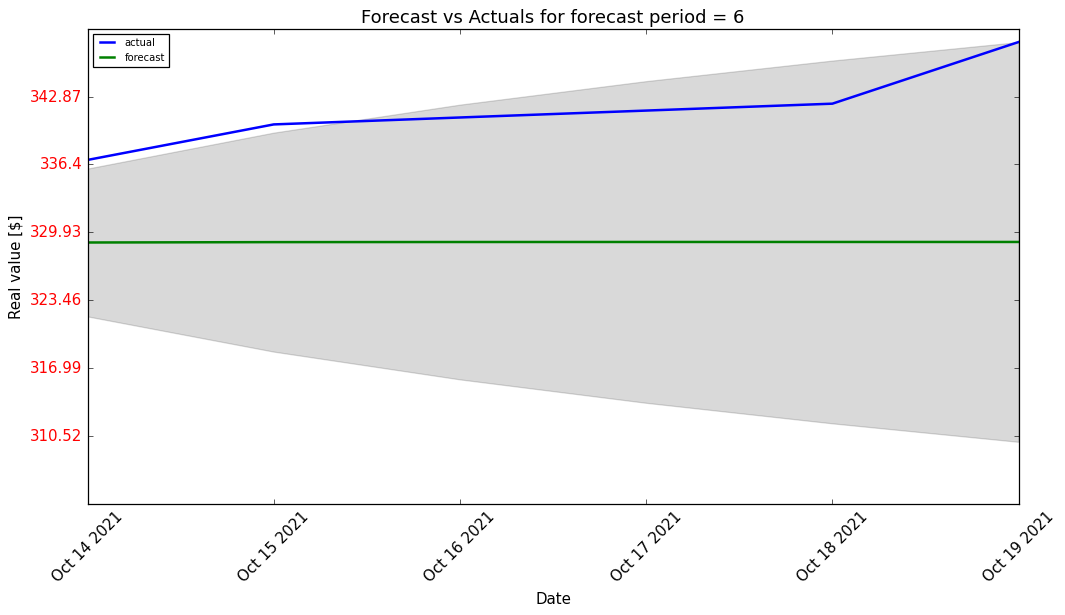

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1     ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2     ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3     ACN  ARIMA(1,1,1)  1  1  1         6  0.039016


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 5004
Model:                 ARIMA(1, 1, 1)   Log Likelihood               15410.500
Date:                Thu, 04 Nov 2021   AIC                         -30814.999
Time:                        19:43:11   BIC                         -30795.446
Sample:                             0   HQIC                        -30808.146
                               - 5004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3164      0.093      3.398      0.001       0.134       0.499
ma.L1         -0.2234      0.094     -2.379      0.017      -0.407      -0.039
sigma2         0.0001   7.97e-07    155.134      0.0

3.285925749214768

5.856061292856436

step: 0.36716222052023834


3.285925749214768
3.6530879697350067
4.020250190255245
4.387412410775484
4.754574631295722
5.12173685181596
5.488899072336199
5.856061292856438


[3.29, 3.65, 4.02, 4.39, 4.75, 5.12, 5.49, 5.86]

3.285925749214768

5.856061292856436

26.733721584630885

349.34546122466844

step: 46.08739137714822


26.733721584630885
72.82111296177911
118.90850433892733
164.99589571607555
211.08328709322376
257.17067847037197
303.25806984752023
349.34546122466844


[26.73, 72.82, 118.91, 165.0, 211.08, 257.17, 303.26, 349.35]

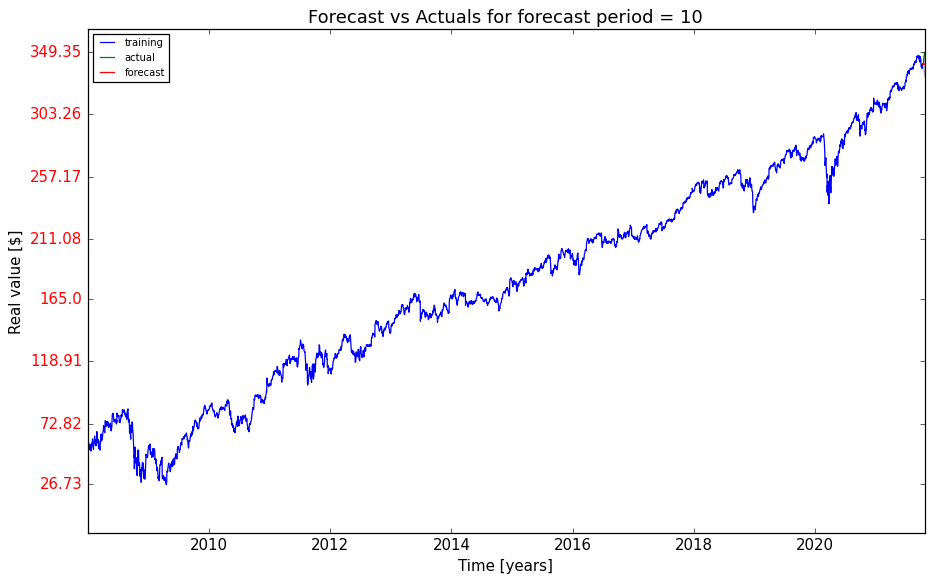

min value 5.711233625373131 max value 5.865149950141834
min value 5.71 max value 5.87
step: 0.02




'final y list'

[5.71, 5.73, 5.75, 5.77, 5.79, 5.81, 5.83, 5.85, 5.87]

min value 5.711233625373131 max value 5.865149950141834
min exp value 302.24 max exp value 352.54
step: 8.38




'final y exp list'

[302.24, 310.62, 319.0, 327.38, 335.76, 344.14, 352.52]

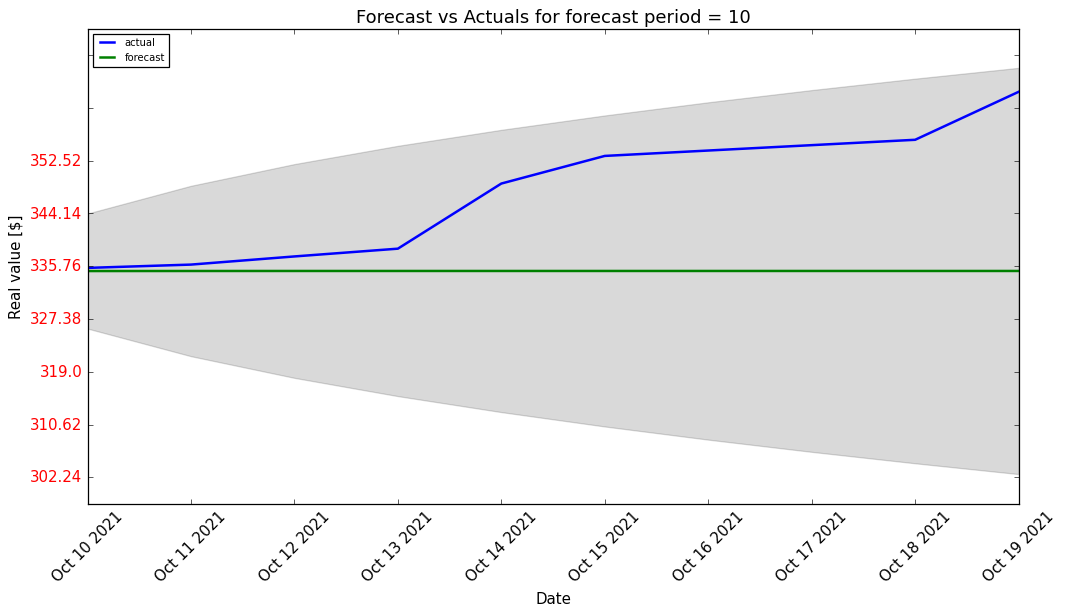

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1     ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2     ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3     ACN  ARIMA(1,1,1)  1  1  1         6  0.039016
4     ACN  ARIMA(1,1,1)  1  1  1        10  0.030514
                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 4984
Model:                 ARIMA(1, 1, 1)   Log Likelihood               15348.052
Date:                Thu, 04 Nov 2021   AIC                         -30690.104
Time:                        19:43:14   BIC                         -30670.562
Sample:                             0   HQIC                        -30683.254
                               - 4984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P

3.285925749214768

5.856061292856436

step: 0.36716222052023834


3.285925749214768
3.6530879697350067
4.020250190255245
4.387412410775484
4.754574631295722
5.12173685181596
5.488899072336199
5.856061292856438


[3.29, 3.65, 4.02, 4.39, 4.75, 5.12, 5.49, 5.86]

3.285925749214768

5.856061292856436

26.733721584630885

349.34546122466844

step: 46.08739137714822


26.733721584630885
72.82111296177911
118.90850433892733
164.99589571607555
211.08328709322376
257.17067847037197
303.25806984752023
349.34546122466844


[26.73, 72.82, 118.91, 165.0, 211.08, 257.17, 303.26, 349.35]

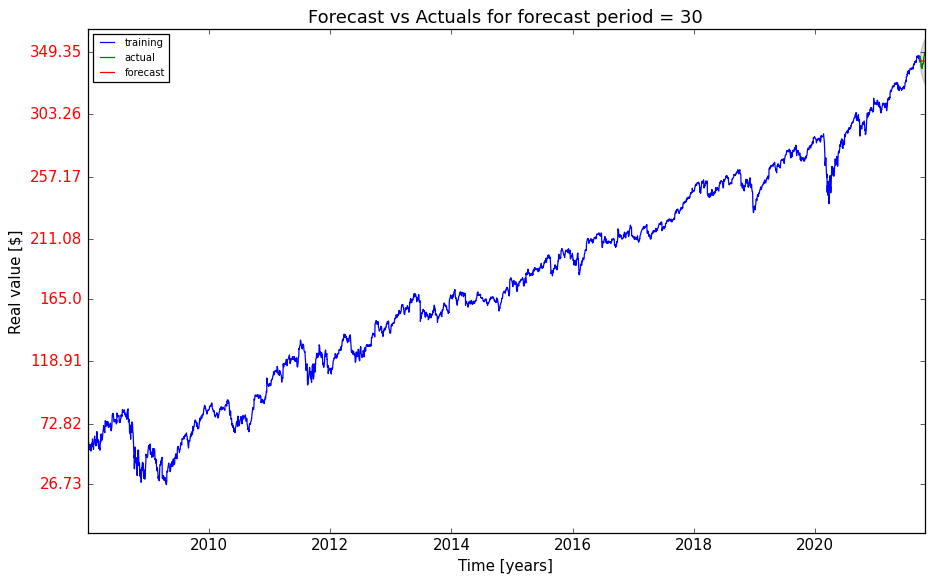

min value 5.672544037827176 max value 5.942128824743682
min value 5.67 max value 5.94
step: 0.04




'final y list'

[5.67, 5.71, 5.75, 5.79, 5.83, 5.87, 5.91, 5.95]

min value 5.672544037827176 max value 5.942128824743682
min exp value 290.77 max exp value 380.74
step: 15.0




'final y exp list'

[290.77, 305.77, 320.77, 335.77, 350.77, 365.77]

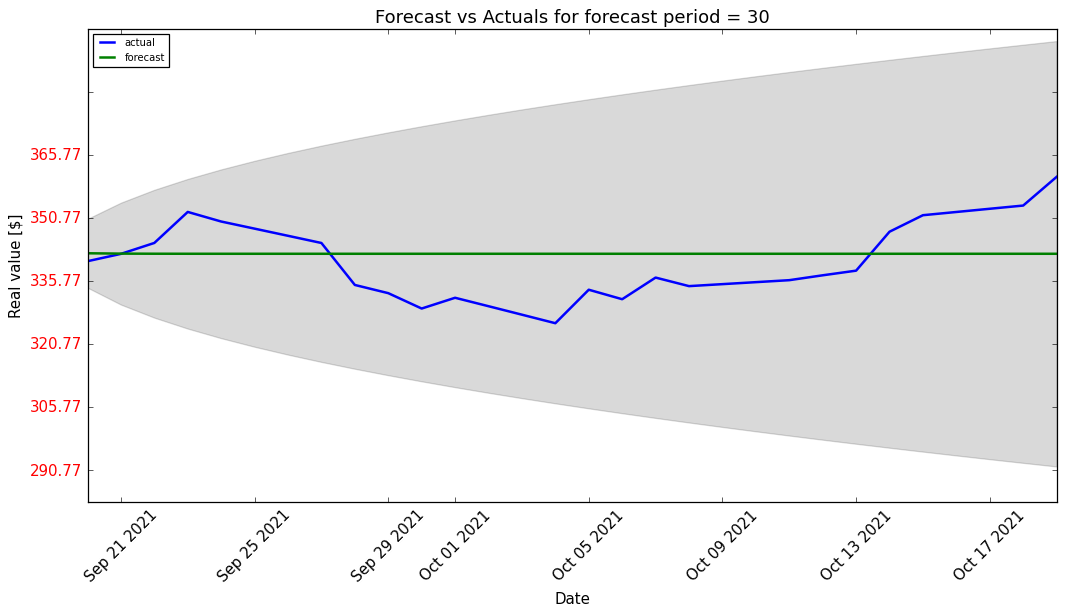

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1     ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2     ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3     ACN  ARIMA(1,1,1)  1  1  1         6  0.039016
4     ACN  ARIMA(1,1,1)  1  1  1        10  0.030514
5     ACN  ARIMA(1,1,1)  1  1  1        30  0.021813
counter 1
AMZN


,timestamp,avg_price
0,2008-01-02,95.995534
1,2008-01-03,96.072367
2,2008-01-04,90.446724
3,2008-01-05,89.823779
4,2008-01-06,89.200835
...,...,...
4905,2021-07-03,3514.224080
4906,2021-07-04,3553.809078
4907,2021-07-05,3593.394076
4908,2021-07-06,3632.979074


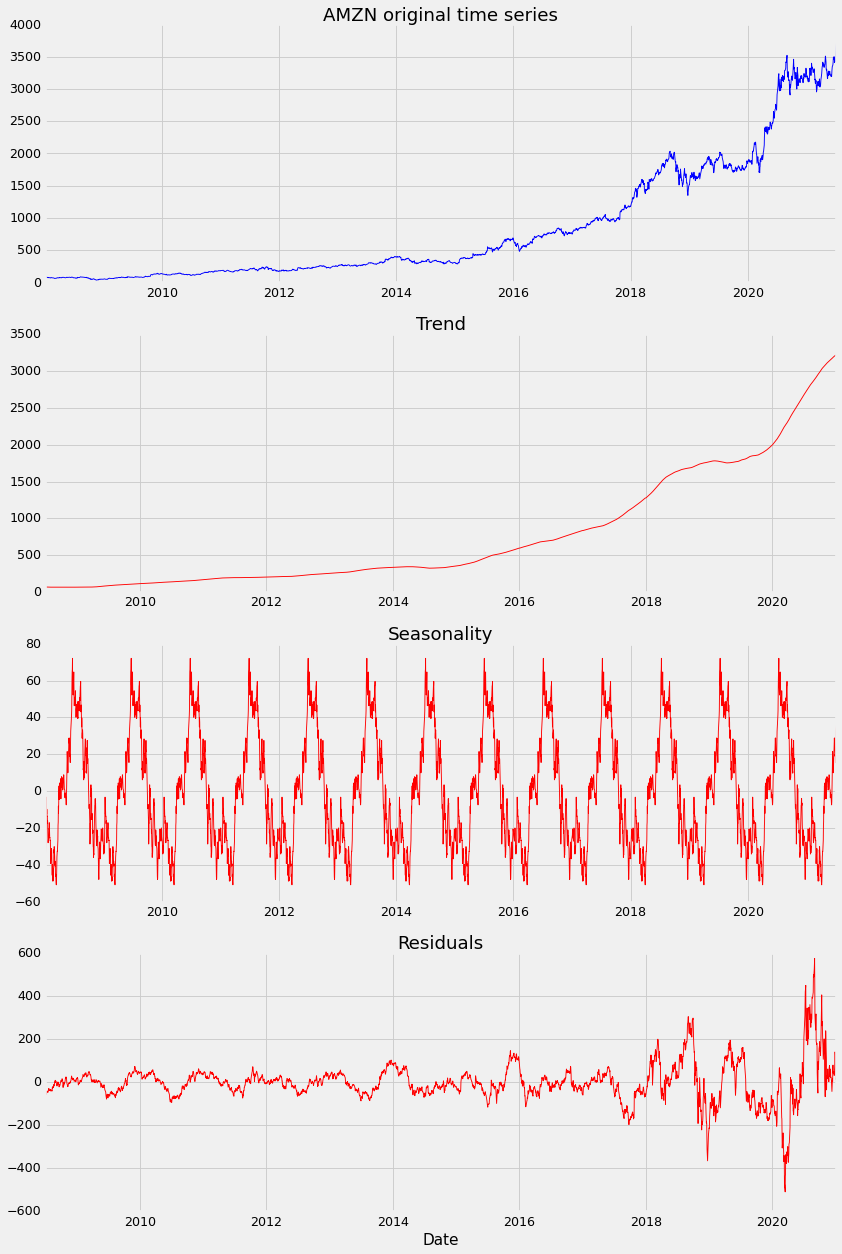

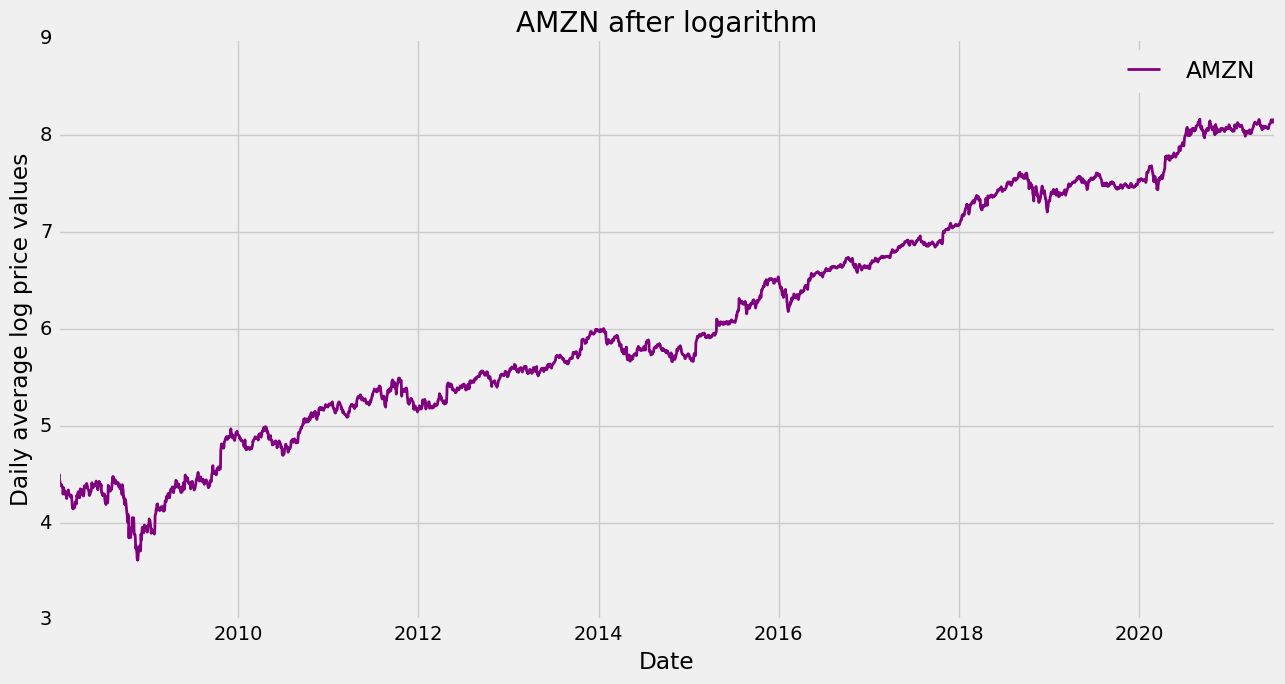

,timestamp,avg_price
0,2008-01-02,4.564302
1,2008-01-03,4.565102
2,2008-01-04,4.504761
3,2008-01-05,4.497850
4,2008-01-06,4.490890
...,...,...
4905,2021-07-03,8.164574
4906,2021-07-04,8.175775
4907,2021-07-05,8.186852
4908,2021-07-06,8.197808


0.17526683400371523 -3.4316838889956798


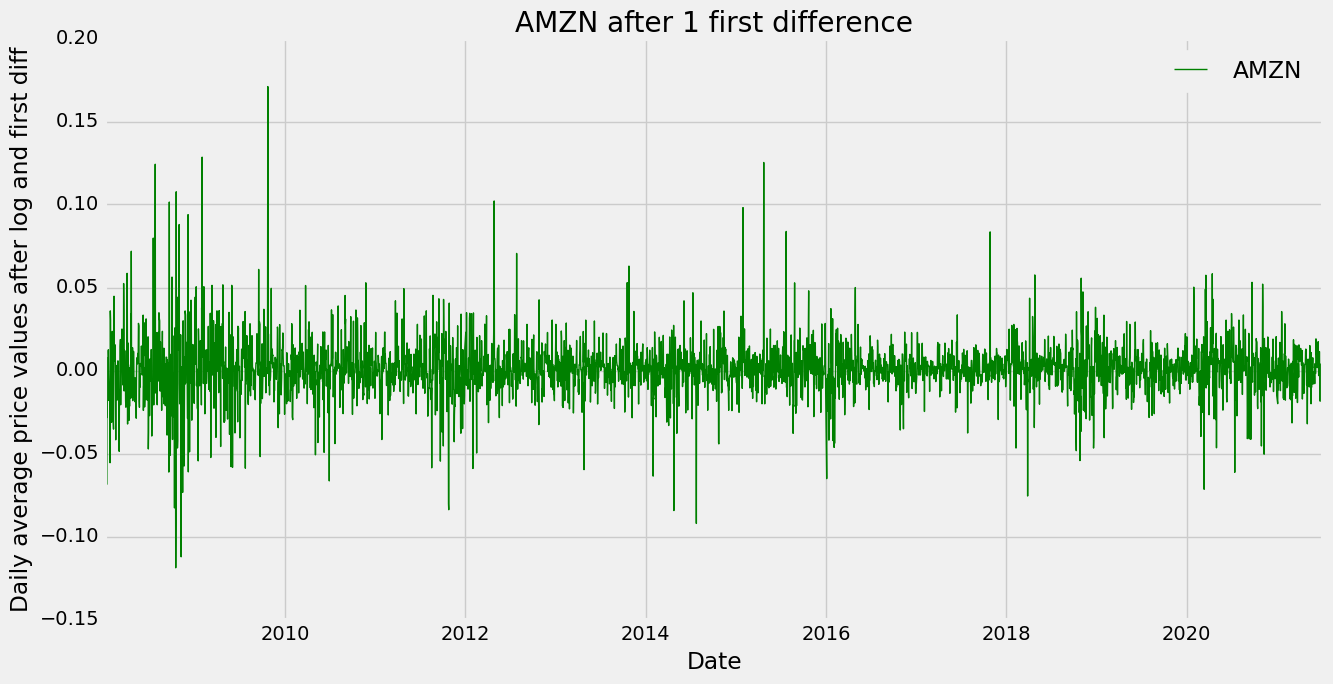

Number of first diff = 1
-34.30016791089735 -3.4316838889956798
Number of performed first diff = 1


'Original dataframe'

,timestamp,avg_price
0,2008-01-02,4.564302
1,2008-01-03,4.565102
2,2008-01-04,4.504761
3,2008-01-05,4.497850
4,2008-01-06,4.490890
...,...,...
4905,2021-07-03,8.164574
4906,2021-07-04,8.175775
4907,2021-07-05,8.186852
4908,2021-07-06,8.197808


'First differenced dataframe'

,timestamp,diff_price
0,2008-01-03,0.000800
1,2008-01-04,-0.060341
2,2008-01-05,-0.006911
3,2008-01-06,-0.006959
4,2008-01-07,-0.007008
...,...,...
4904,2021-07-03,0.011328
4905,2021-07-04,0.011201
4906,2021-07-05,0.011077
4907,2021-07-06,0.010956


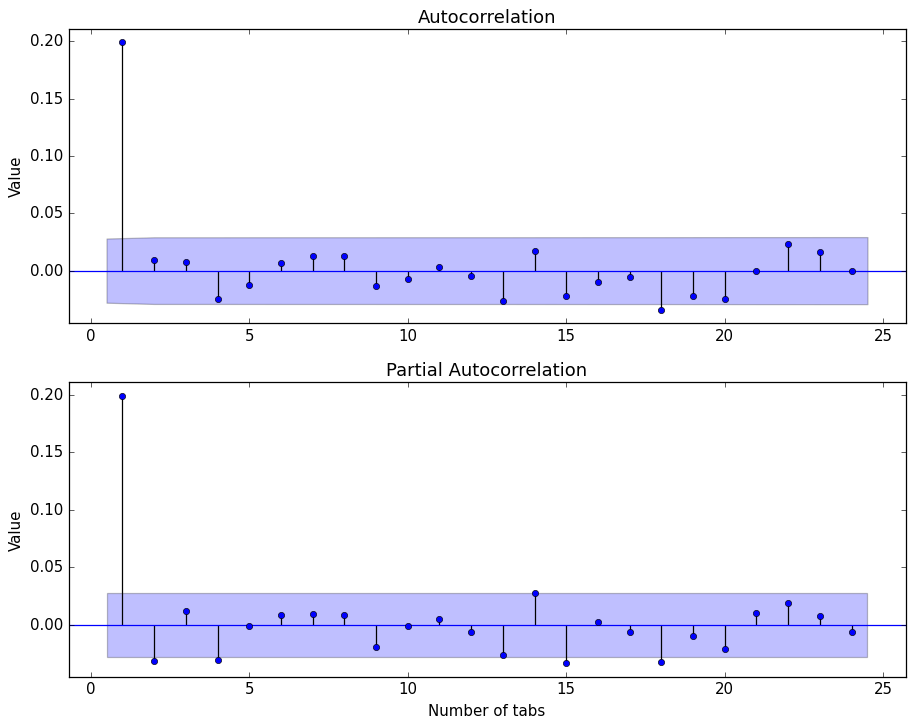

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

[-24900.23028495728, -27188.003382410054, -27394.238109691243, -27385.787500558454, -27379.494594682677, -27388.782666575797, -27384.608404816954, -27381.966810277423, -25672.16828399752, -27387.909896882724, -27391.079348843938, -27396.520483807246, -27387.8378832922, -27396.345695658063, -27380.58452133556, -27375.060296429016, -26154.396183926572, -27397.114341269415, -27377.92942680018, -27387.5070584366, -27385.61515891767, -27383.18791083859, -27373.167778863797, -27364.781708679802, -26351.69894814707, -27376.796190318673, -27384.721923549245, -27386.83037584515, -27339.87676229074, -27378.07899837236, -27306.8539944405, -27360.084621393613, -26529.143832851732, -27332.004276584565, -27324.496125076053, -27387.513414339577, -27363.08322746842, -27365.024146273972, -27363.744611854032, -27358.966414406364, -26666.53060329872, -27352.407229799963, -27346.24227359377, -27338.51571364869, -27351.09125744681, -27337.902794334703, -27365.786680427154, -27330.598455404768, -26780.41226

,ARIMA,p,d,q,AIC,BIC
0,"ARIMA(0,1,0)",0,1,0,-24900.230285,-24893.731867
1,"ARIMA(0,1,1)",0,1,1,-27188.003382,-27175.006954
2,"ARIMA(0,1,2)",0,1,2,-27394.238110,-27374.744079
3,"ARIMA(0,1,3)",0,1,3,-27385.787501,-27359.796275
4,"ARIMA(0,1,4)",0,1,4,-27379.494595,-27347.006582
...,...,...,...,...,...,...
59,"ARIMA(7,1,3)",7,1,3,-27315.716722,-27244.247582
60,"ARIMA(7,1,4)",7,1,4,-27271.032838,-27193.066503
61,"ARIMA(7,1,5)",7,1,5,-27312.384723,-27227.921194
62,"ARIMA(7,1,6)",7,1,6,-27292.689535,-27201.728811


Best ARIMA according to AIC criterium:
ARIMA    ARIMA(2,1,1)
p                   2
d                   1
q                   1
AIC          -27397.1
BIC          -27371.1
Name: 17, dtype: object

Best ARIMA according to BIC criterium:
ARIMA    ARIMA(0,1,2)
p                   0
d                   1
q                   2
AIC          -27394.2
BIC          -27374.7
Name: 2, dtype: object


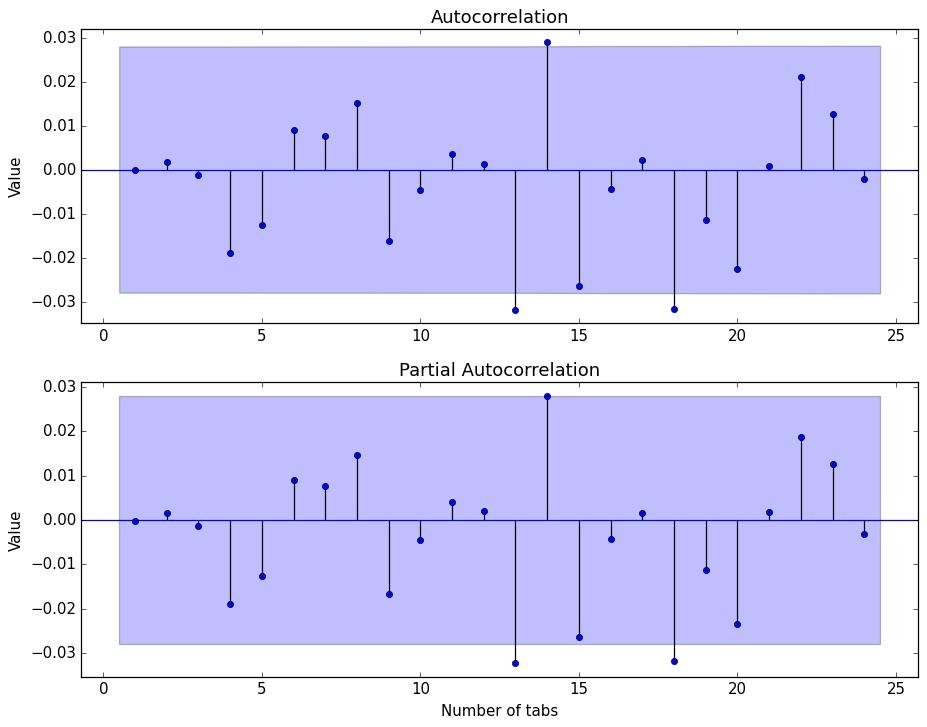

                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 4904
Model:                 ARIMA(2, 1, 1)   Log Likelihood               13688.590
Date:                Thu, 04 Nov 2021   AIC                         -27369.181
Time:                        19:54:17   BIC                         -27343.190
Sample:                             0   HQIC                        -27360.063
                               - 4904                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2485      0.271     -0.915      0.360      -0.781       0.284
ar.L2          0.0614      0.057      1.073      0.283      -0.051       0.174
ma.L1          0.4561      0.271      1.686      0.0

3.6146300361494115

8.217536215469567

step: 0.657558025617165


3.6146300361494115
4.272188061766577
4.929746087383742
5.587304113000907
6.244862138618072
6.902420164235237
7.559978189852402
8.217536215469568


[3.61, 4.27, 4.93, 5.59, 6.24, 6.9, 7.56, 8.22]

3.6146300361494115

8.217536215469567

37.137603812852554

3705.3619136995685

step: 524.0320442695308


37.137603812852554
561.1696480823834
1085.2016923519143
1609.2337366214451
2133.2657808909757
2657.297825160507
3181.3298694300374
3705.361913699568


[37.14, 561.17, 1085.2, 1609.23, 2133.27, 2657.3, 3181.33, 3705.36]

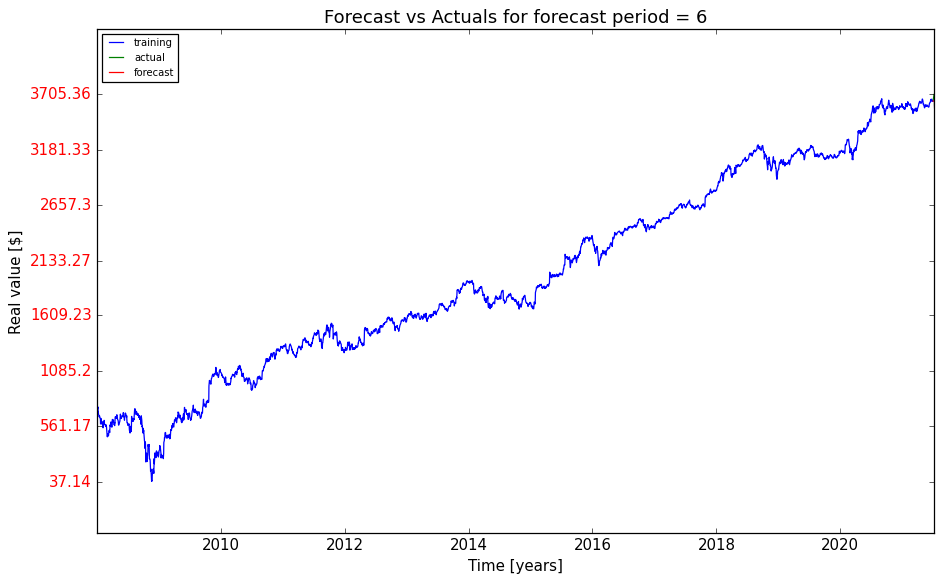

min value 8.054018799104929 max value 8.223067580172378
min value 8.05 max value 8.22
step: 0.02




'final y list'

[8.05, 8.07, 8.09, 8.11, 8.13, 8.15, 8.17, 8.19, 8.21, 8.23]

min value 8.054018799104929 max value 8.223067580172378
min exp value 3146.41 max exp value 3725.91
step: 96.58




'final y exp list'

[3146.41, 3242.99, 3339.57, 3436.15, 3532.73, 3629.31, 3725.89]

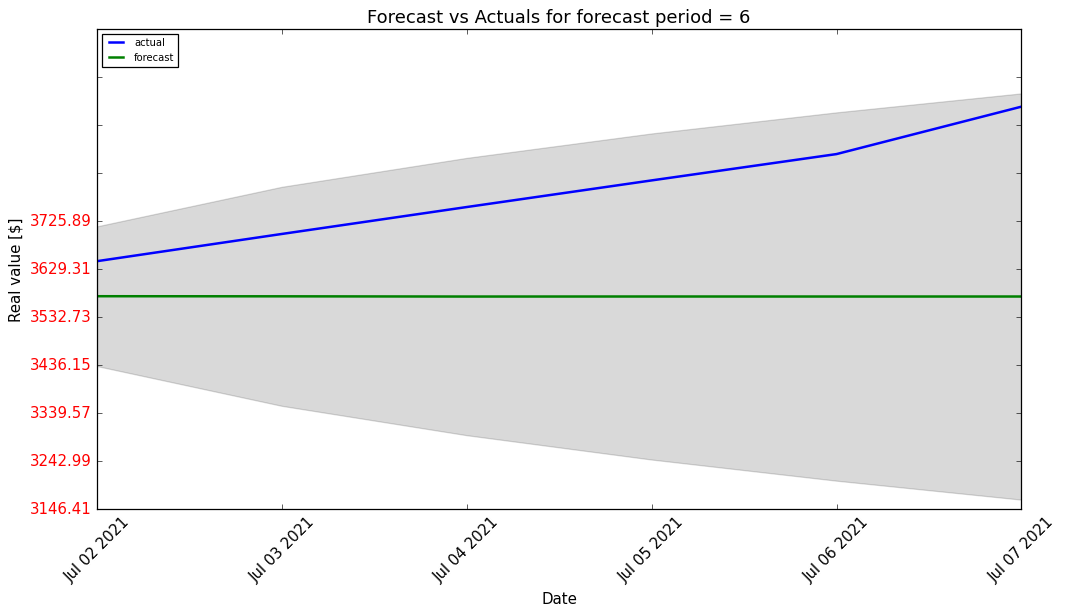

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1     ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2     ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3     ACN  ARIMA(1,1,1)  1  1  1         6  0.039016
4     ACN  ARIMA(1,1,1)  1  1  1        10  0.030514
5     ACN  ARIMA(1,1,1)  1  1  1        30  0.021813
6    AMZN  ARIMA(2,1,1)  2  1  1         6  0.044057
                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 4900
Model:                 ARIMA(2, 1, 1)   Log Likelihood               13675.636
Date:                Thu, 04 Nov 2021   AIC                         -27343.272
Time:                        19:54:21   BIC                         -27317.285
Sample:                             0   HQIC                        -27334.155
                               - 4900                                         
Covariance Type:       

3.6146300361494115

8.217536215469567

step: 0.657558025617165


3.6146300361494115
4.272188061766577
4.929746087383742
5.587304113000907
6.244862138618072
6.902420164235237
7.559978189852402
8.217536215469568


[3.61, 4.27, 4.93, 5.59, 6.24, 6.9, 7.56, 8.22]

3.6146300361494115

8.217536215469567

37.137603812852554

3705.3619136995685

step: 524.0320442695308


37.137603812852554
561.1696480823834
1085.2016923519143
1609.2337366214451
2133.2657808909757
2657.297825160507
3181.3298694300374
3705.361913699568


[37.14, 561.17, 1085.2, 1609.23, 2133.27, 2657.3, 3181.33, 3705.36]

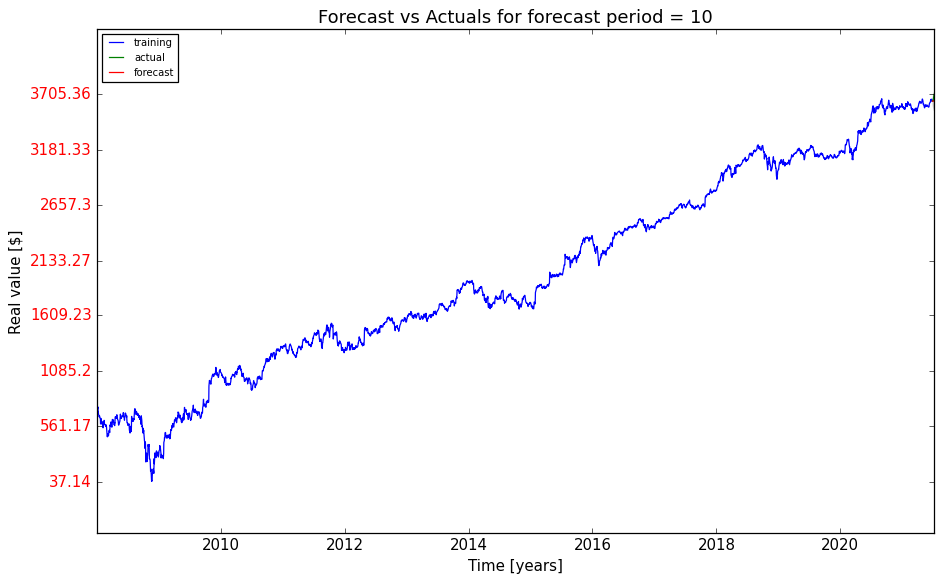

min value 8.028402679642358 max value 8.249661395715965
min value 8.03 max value 8.25
step: 0.03




'final y list'

[8.03, 8.06, 8.09, 8.12, 8.15, 8.18, 8.21, 8.24, 8.27]

min value 8.028402679642358 max value 8.249661395715965
min exp value 3066.84 max exp value 3826.33
step: 126.58




'final y exp list'

[3066.84, 3193.42, 3320.0, 3446.58, 3573.16, 3699.74, 3826.32]

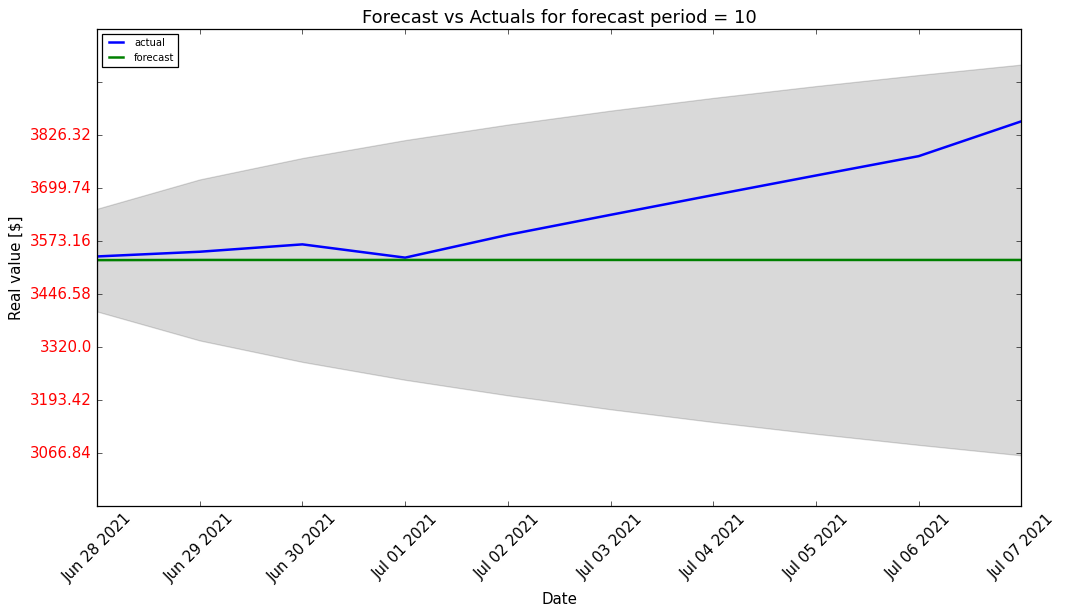

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1     ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2     ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3     ACN  ARIMA(1,1,1)  1  1  1         6  0.039016
4     ACN  ARIMA(1,1,1)  1  1  1        10  0.030514
5     ACN  ARIMA(1,1,1)  1  1  1        30  0.021813
6    AMZN  ARIMA(2,1,1)  2  1  1         6  0.044057
7    AMZN  ARIMA(2,1,1)  2  1  1        10  0.027846


C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 4880
Model:                 ARIMA(2, 1, 1)   Log Likelihood               13613.105
Date:                Thu, 04 Nov 2021   AIC                         -27218.210
Time:                        19:54:26   BIC                         -27192.239
Sample:                             0   HQIC                        -27209.096
                               - 4880                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2564      0.267     -0.960      0.337      -0.780       0.267
ar.L2          0.0628      0.056      1.115      0.265      -0.048       0.173
ma.L1          0.4637      0.266      1.741      0.0

3.6146300361494115

8.217536215469567

step: 0.657558025617165


3.6146300361494115
4.272188061766577
4.929746087383742
5.587304113000907
6.244862138618072
6.902420164235237
7.559978189852402
8.217536215469568


[3.61, 4.27, 4.93, 5.59, 6.24, 6.9, 7.56, 8.22]

3.6146300361494115

8.217536215469567

37.137603812852554

3705.3619136995685

step: 524.0320442695308


37.137603812852554
561.1696480823834
1085.2016923519143
1609.2337366214451
2133.2657808909757
2657.297825160507
3181.3298694300374
3705.361913699568


[37.14, 561.17, 1085.2, 1609.23, 2133.27, 2657.3, 3181.33, 3705.36]

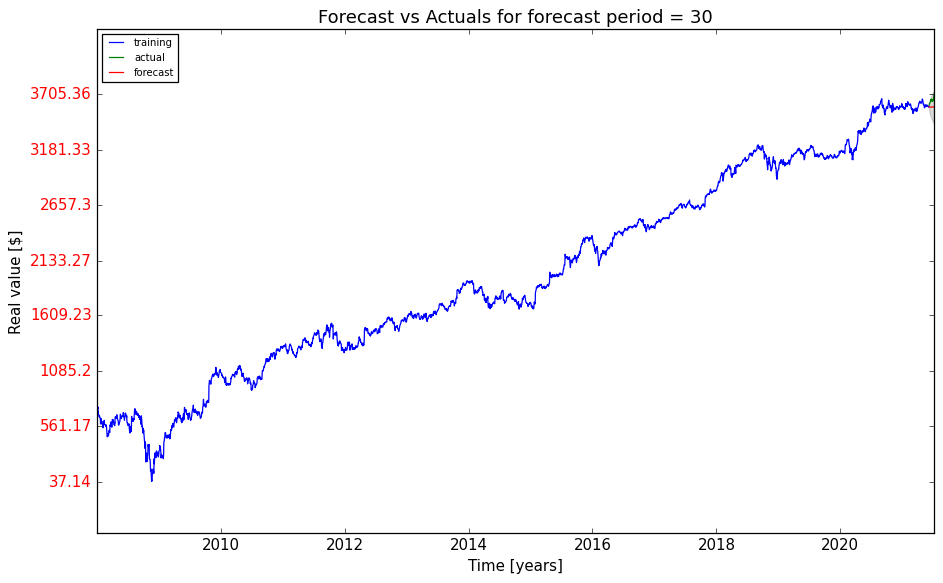

min value 7.874032863988428 max value 8.262681693228435
min value 7.87 max value 8.26
step: 0.06




'final y list'

[7.87, 7.93, 7.99, 8.05, 8.11, 8.17, 8.23, 8.29]

min value 7.874032863988428 max value 8.262681693228435
min exp value 2628.14 max exp value 3876.48
step: 208.06




'final y exp list'

[2628.14, 2836.2, 3044.26, 3252.32, 3460.38, 3668.44]

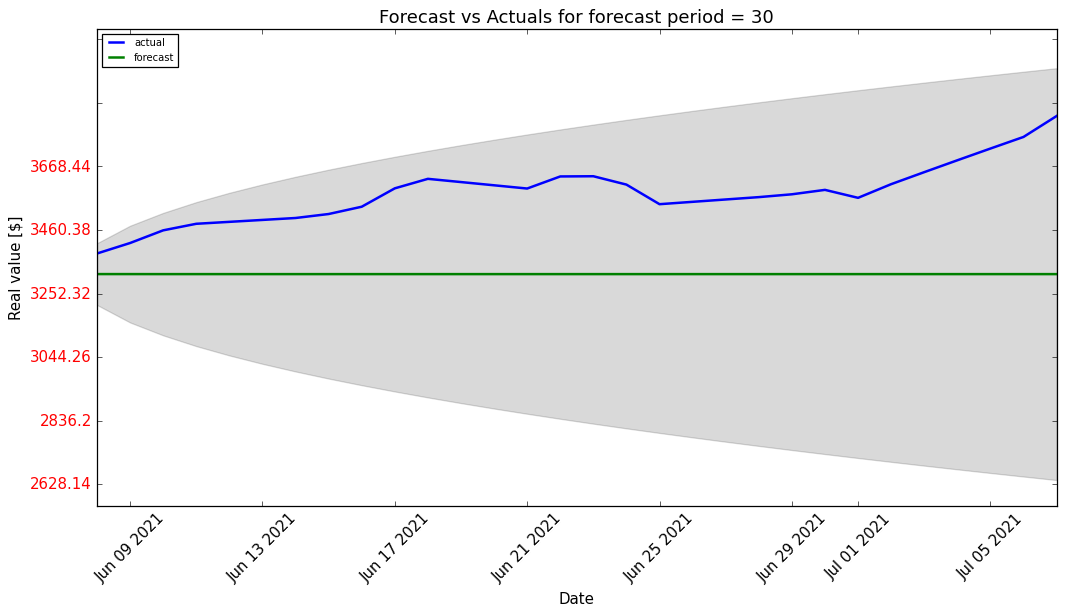

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1     ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2     ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3     ACN  ARIMA(1,1,1)  1  1  1         6  0.039016
4     ACN  ARIMA(1,1,1)  1  1  1        10  0.030514
5     ACN  ARIMA(1,1,1)  1  1  1        30  0.021813
6    AMZN  ARIMA(2,1,1)  2  1  1         6  0.044057
7    AMZN  ARIMA(2,1,1)  2  1  1        10  0.027846
8    AMZN  ARIMA(2,1,1)  2  1  1        30  0.076412


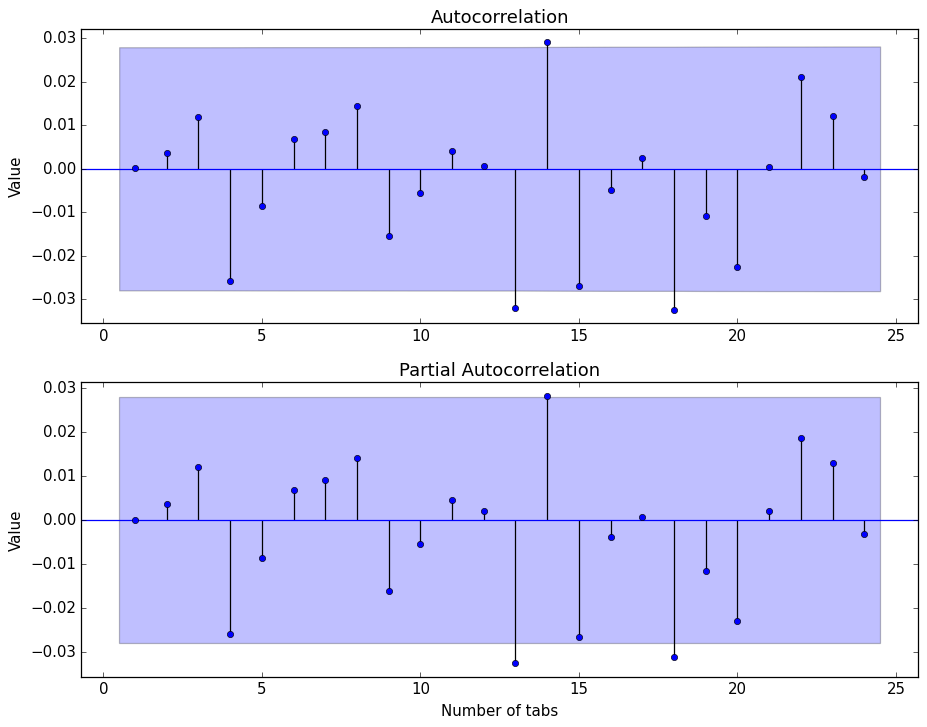

                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 4904
Model:                 ARIMA(0, 1, 2)   Log Likelihood               13687.777
Date:                Thu, 04 Nov 2021   AIC                         -27369.555
Time:                        19:54:29   BIC                         -27350.062
Sample:                             0   HQIC                        -27362.716
                               - 4904                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2080      0.008     25.336      0.000       0.192       0.224
ma.L2          0.0094      0.009      1.017      0.309      -0.009       0.027
sigma2         0.0002   1.66e-06    132.135      0.0

3.6146300361494115

8.217536215469567

step: 0.657558025617165


3.6146300361494115
4.272188061766577
4.929746087383742
5.587304113000907
6.244862138618072
6.902420164235237
7.559978189852402
8.217536215469568


[3.61, 4.27, 4.93, 5.59, 6.24, 6.9, 7.56, 8.22]

3.6146300361494115

8.217536215469567

37.137603812852554

3705.3619136995685

step: 524.0320442695308


37.137603812852554
561.1696480823834
1085.2016923519143
1609.2337366214451
2133.2657808909757
2657.297825160507
3181.3298694300374
3705.361913699568


[37.14, 561.17, 1085.2, 1609.23, 2133.27, 2657.3, 3181.33, 3705.36]

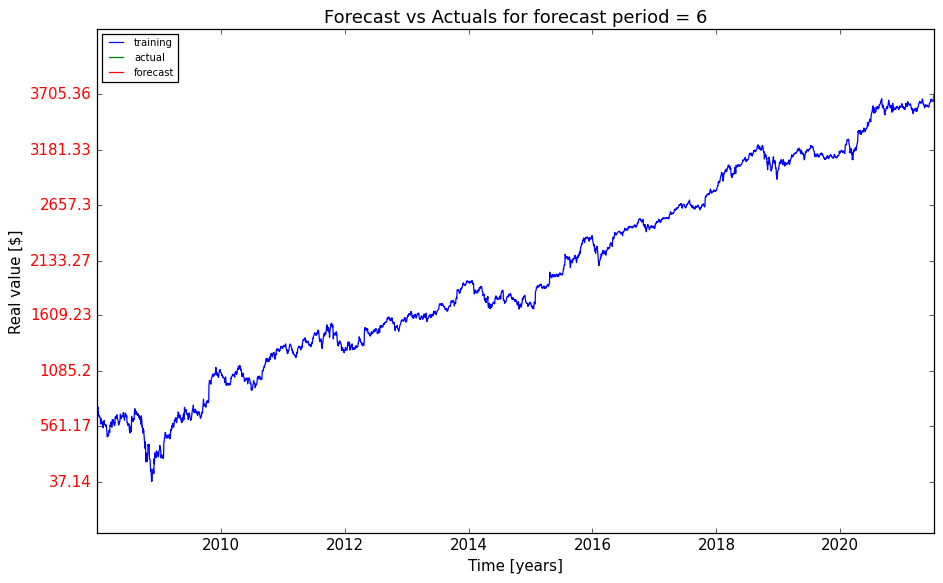

min value 8.054384407791854 max value 8.222766687099611
min value 8.05 max value 8.22
step: 0.02




'final y list'

[8.05, 8.07, 8.09, 8.11, 8.13, 8.15, 8.17, 8.19, 8.21, 8.23]

min value 8.054384407791854 max value 8.222766687099611
min exp value 3147.56 max exp value 3724.79
step: 96.2




'final y exp list'

[3147.56, 3243.76, 3339.96, 3436.16, 3532.36, 3628.56, 3724.76]

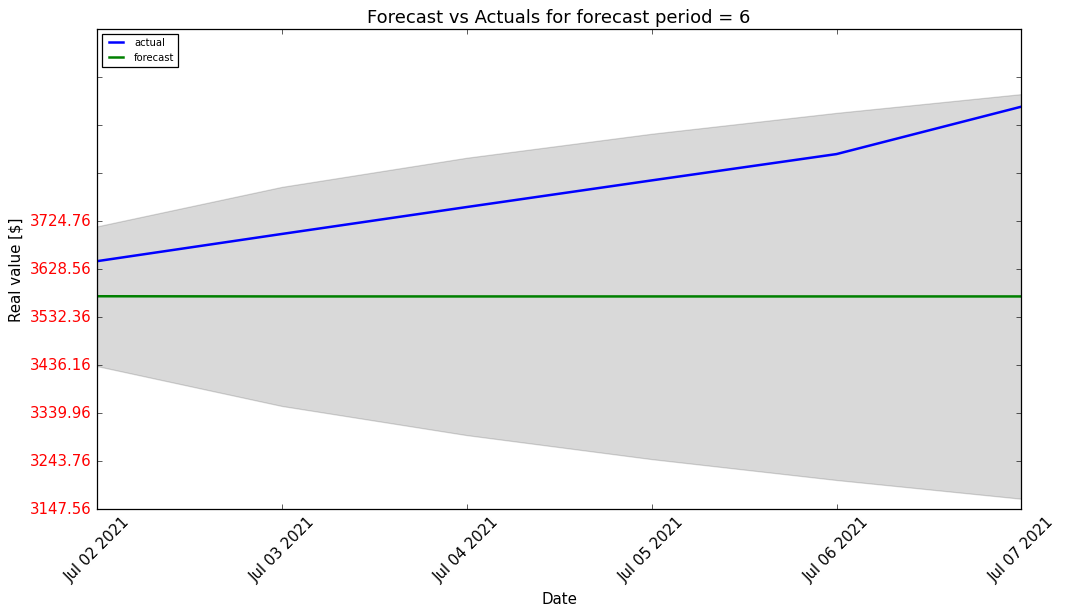

  Company         ARIMA  p  d  q fc_period       MAE
0     ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1     ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2     ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3     ACN  ARIMA(1,1,1)  1  1  1         6  0.039016
4     ACN  ARIMA(1,1,1)  1  1  1        10  0.030514
5     ACN  ARIMA(1,1,1)  1  1  1        30  0.021813
6    AMZN  ARIMA(2,1,1)  2  1  1         6  0.044057
7    AMZN  ARIMA(2,1,1)  2  1  1        10  0.027846
8    AMZN  ARIMA(2,1,1)  2  1  1        30  0.076412
9    AMZN  ARIMA(0,1,2)  0  1  2         6  0.044044
                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 4900
Model:                 ARIMA(0, 1, 2)   Log Likelihood               13674.819
Date:                Thu, 04 Nov 2021   AIC                         -27343.637
Time:                        19:54:32   BIC                         -27324.147
Sample:               

3.6146300361494115

8.217536215469567

step: 0.657558025617165


3.6146300361494115
4.272188061766577
4.929746087383742
5.587304113000907
6.244862138618072
6.902420164235237
7.559978189852402
8.217536215469568


[3.61, 4.27, 4.93, 5.59, 6.24, 6.9, 7.56, 8.22]

3.6146300361494115

8.217536215469567

37.137603812852554

3705.3619136995685

step: 524.0320442695308


37.137603812852554
561.1696480823834
1085.2016923519143
1609.2337366214451
2133.2657808909757
2657.297825160507
3181.3298694300374
3705.361913699568


[37.14, 561.17, 1085.2, 1609.23, 2133.27, 2657.3, 3181.33, 3705.36]

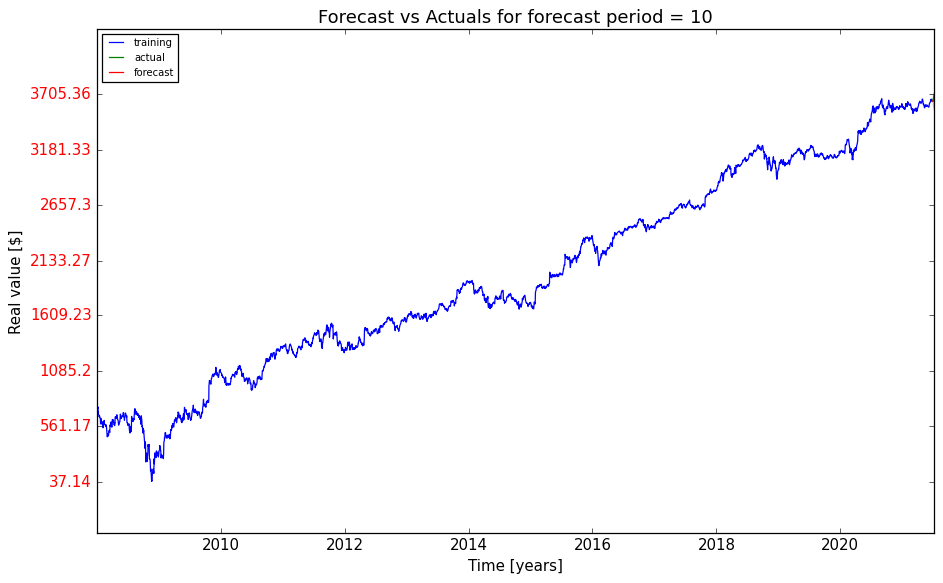

min value 8.029073200168517 max value 8.24913720172176
min value 8.03 max value 8.25
step: 0.03




'final y list'

[8.03, 8.06, 8.09, 8.12, 8.15, 8.18, 8.21, 8.24, 8.27]

min value 8.029073200168517 max value 8.24913720172176
min exp value 3068.9 max exp value 3824.32
step: 125.9




'final y exp list'

[3068.9, 3194.8, 3320.7, 3446.6, 3572.5, 3698.4, 3824.3]

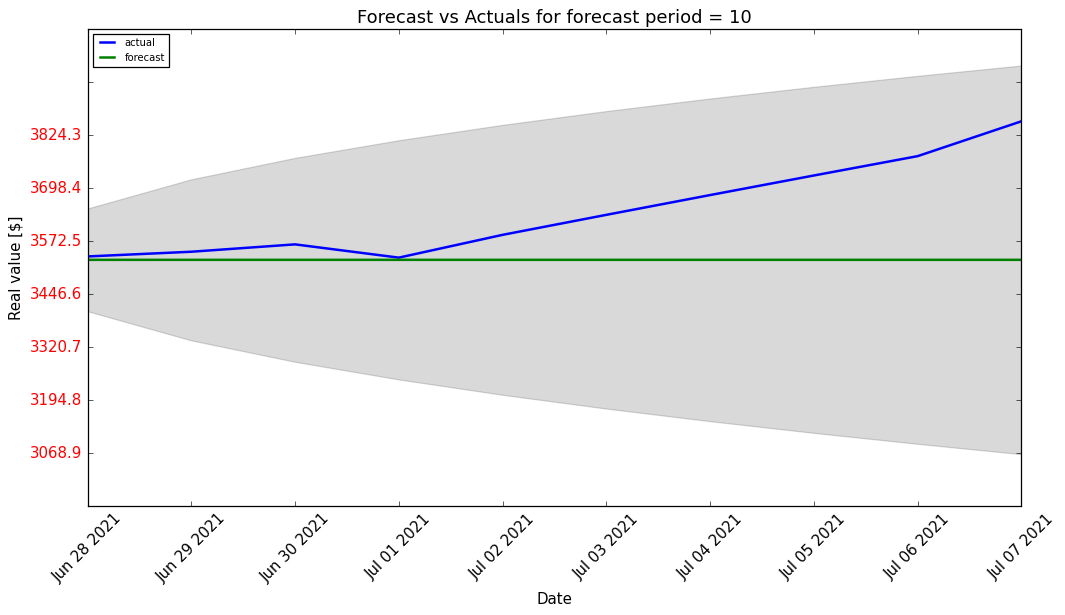

   Company         ARIMA  p  d  q fc_period       MAE
0      ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1      ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2      ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3      ACN  ARIMA(1,1,1)  1  1  1         6  0.039016
4      ACN  ARIMA(1,1,1)  1  1  1        10  0.030514
5      ACN  ARIMA(1,1,1)  1  1  1        30  0.021813
6     AMZN  ARIMA(2,1,1)  2  1  1         6  0.044057
7     AMZN  ARIMA(2,1,1)  2  1  1        10  0.027846
8     AMZN  ARIMA(2,1,1)  2  1  1        30  0.076412
9     AMZN  ARIMA(0,1,2)  0  1  2         6  0.044044
10    AMZN  ARIMA(0,1,2)  0  1  2        10  0.027765
                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 4880
Model:                 ARIMA(0, 1, 2)   Log Likelihood               13612.263
Date:                Thu, 04 Nov 2021   AIC                         -27218.526
Time:                        19:54:3

3.6146300361494115

8.217536215469567

step: 0.657558025617165


3.6146300361494115
4.272188061766577
4.929746087383742
5.587304113000907
6.244862138618072
6.902420164235237
7.559978189852402
8.217536215469568


[3.61, 4.27, 4.93, 5.59, 6.24, 6.9, 7.56, 8.22]

3.6146300361494115

8.217536215469567

37.137603812852554

3705.3619136995685

step: 524.0320442695308


37.137603812852554
561.1696480823834
1085.2016923519143
1609.2337366214451
2133.2657808909757
2657.297825160507
3181.3298694300374
3705.361913699568


[37.14, 561.17, 1085.2, 1609.23, 2133.27, 2657.3, 3181.33, 3705.36]

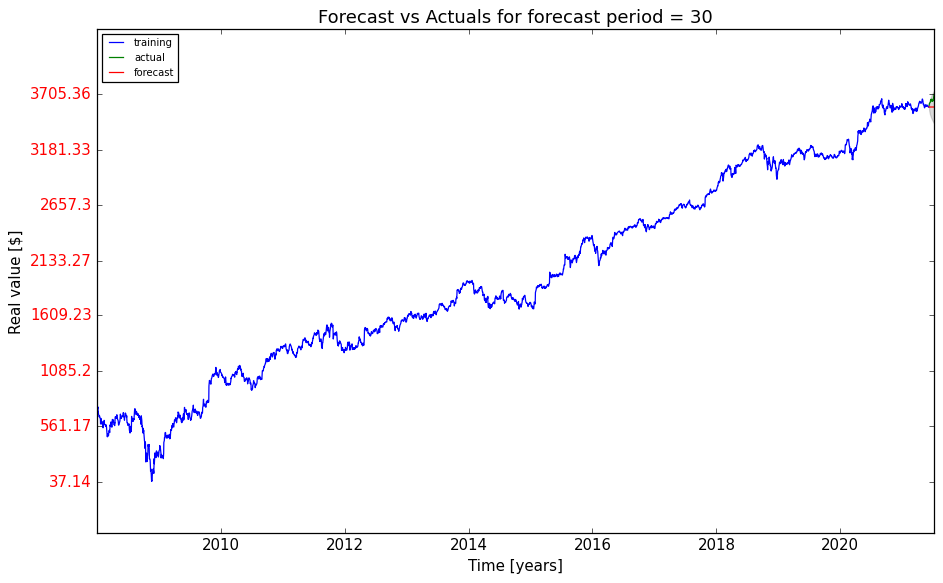

min value 7.87544937260158 max value 8.261432244006738
min value 7.88 max value 8.26
step: 0.05




'final y list'

[7.88, 7.93, 7.98, 8.03, 8.08, 8.13, 8.18, 8.23, 8.28]

min value 7.87544937260158 max value 8.261432244006738
min exp value 2631.87 max exp value 3871.64
step: 206.63




'final y exp list'

[2631.87, 2838.5, 3045.13, 3251.76, 3458.39, 3665.02]

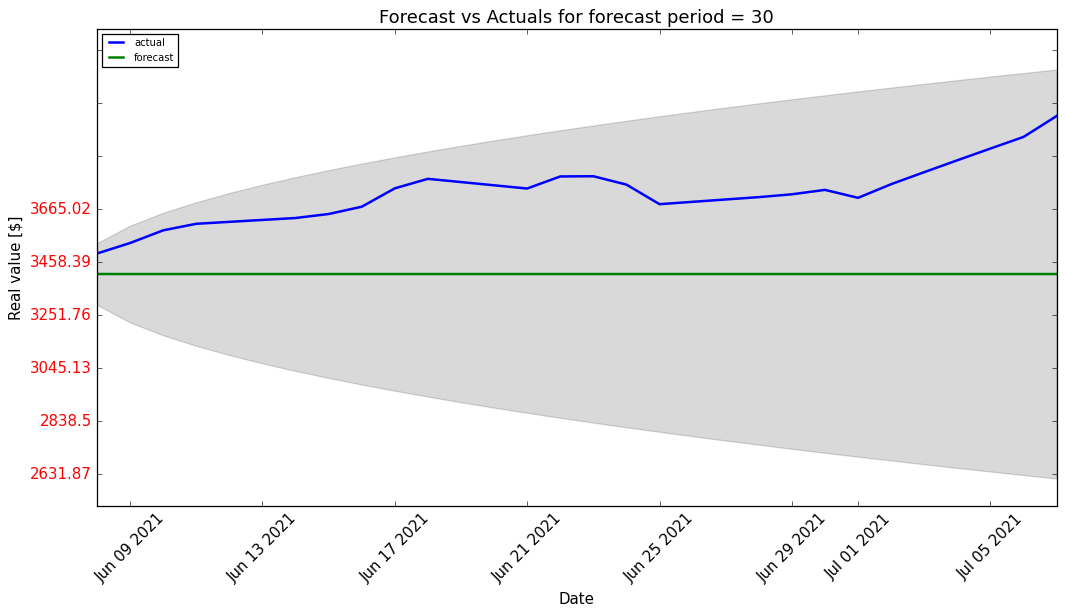

   Company         ARIMA  p  d  q fc_period       MAE
0      ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1      ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2      ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3      ACN  ARIMA(1,1,1)  1  1  1         6  0.039016
4      ACN  ARIMA(1,1,1)  1  1  1        10  0.030514
5      ACN  ARIMA(1,1,1)  1  1  1        30  0.021813
6     AMZN  ARIMA(2,1,1)  2  1  1         6  0.044057
7     AMZN  ARIMA(2,1,1)  2  1  1        10  0.027846
8     AMZN  ARIMA(2,1,1)  2  1  1        30  0.076412
9     AMZN  ARIMA(0,1,2)  0  1  2         6  0.044044
10    AMZN  ARIMA(0,1,2)  0  1  2        10  0.027765
11    AMZN  ARIMA(0,1,2)  0  1  2        30  0.076329
counter 2
ARCB


,timestamp,avg_price
0,2014-05-01,39.041370
1,2014-05-02,38.674239
2,2014-05-03,38.919088
3,2014-05-04,39.163938
4,2014-05-05,39.408787
...,...,...
2718,2021-10-24,89.261799
2719,2021-10-25,89.564201
2720,2021-10-26,89.723779
2721,2021-10-27,87.879773


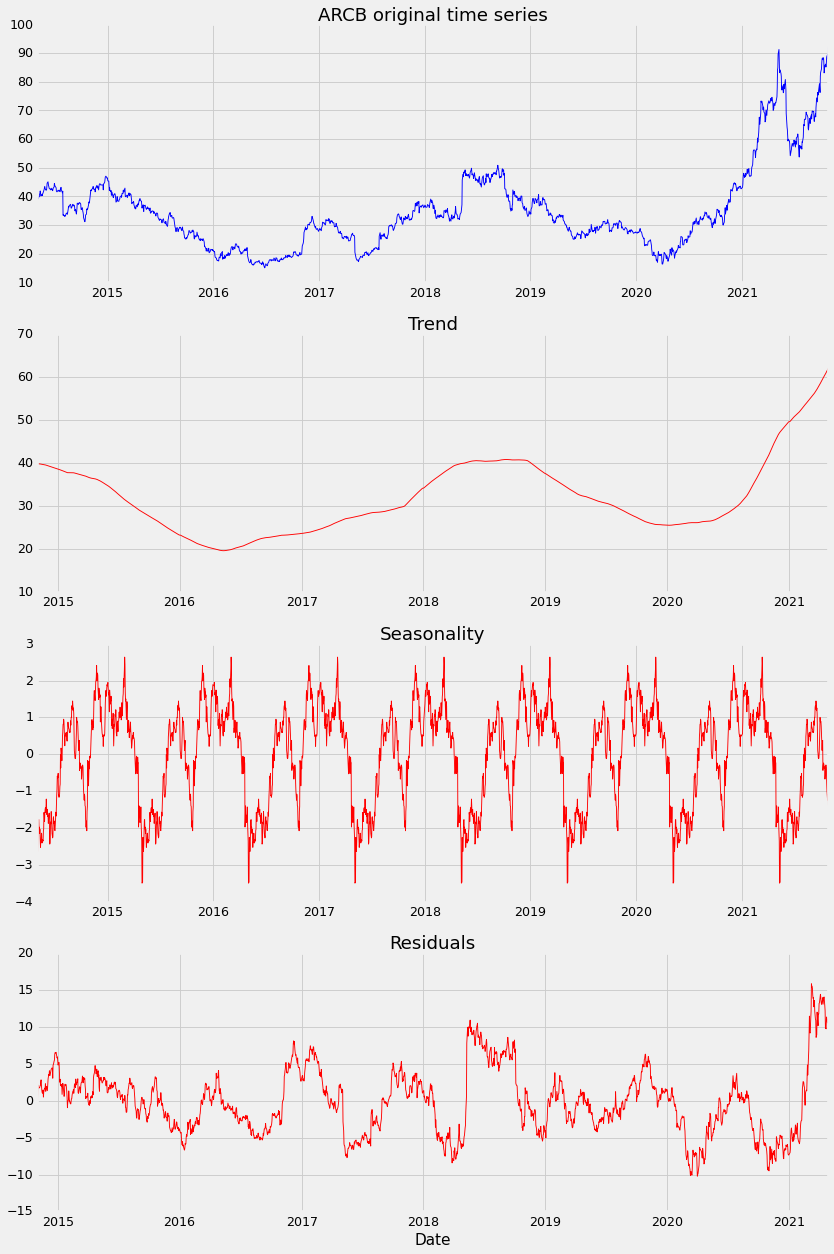

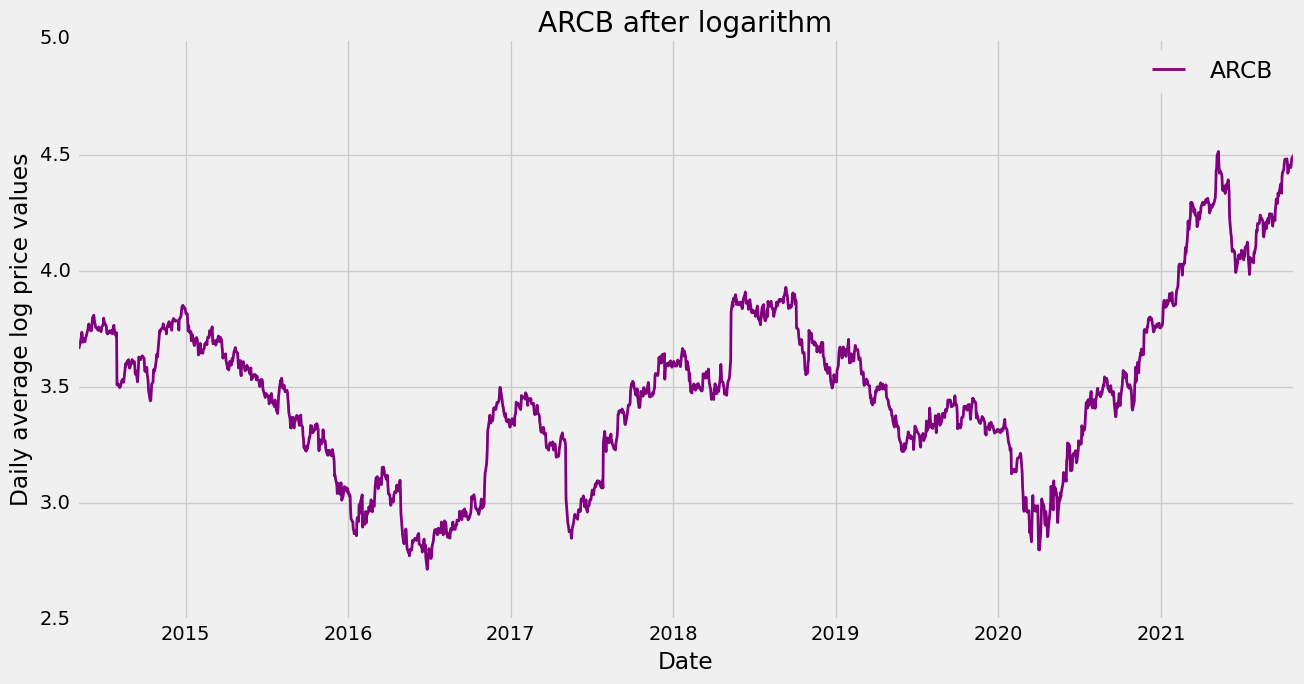

,timestamp,avg_price
0,2014-05-01,3.664622
1,2014-05-02,3.655174
2,2014-05-03,3.661485
3,2014-05-04,3.667756
4,2014-05-05,3.673989
...,...,...
2718,2021-10-24,4.491574
2719,2021-10-25,4.494956
2720,2021-10-26,4.496736
2721,2021-10-27,4.475970


-0.5330597791637616 -3.432755542000777


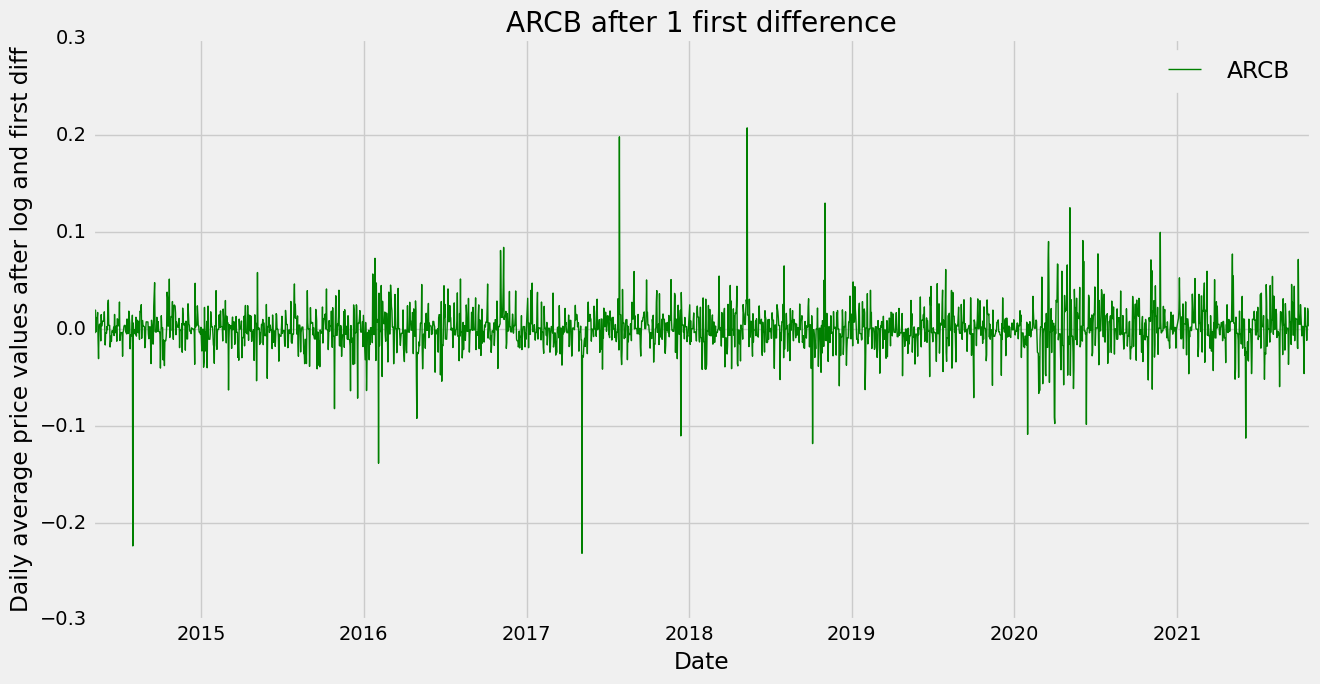

Number of first diff = 1
-45.62295848254238 -3.432755542000777
Number of performed first diff = 1


'Original dataframe'

,timestamp,avg_price
0,2014-05-01,3.664622
1,2014-05-02,3.655174
2,2014-05-03,3.661485
3,2014-05-04,3.667756
4,2014-05-05,3.673989
...,...,...
2718,2021-10-24,4.491574
2719,2021-10-25,4.494956
2720,2021-10-26,4.496736
2721,2021-10-27,4.475970


'First differenced dataframe'

,timestamp,diff_price
0,2014-05-02,-0.009448
1,2014-05-03,0.006311
2,2014-05-04,0.006272
3,2014-05-05,0.006232
4,2014-05-06,-0.004375
...,...,...
2717,2021-10-24,0.003394
2718,2021-10-25,0.003382
2719,2021-10-26,0.001780
2720,2021-10-27,-0.020766


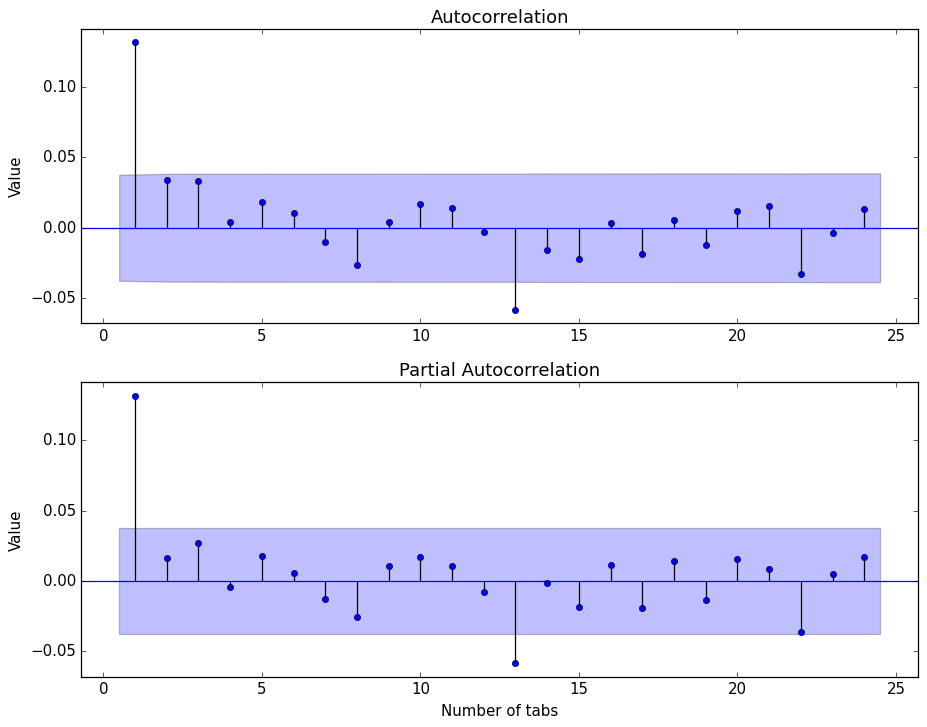

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization fail

C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Darek_PC\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

[-11804.307004595496, -13289.260241589416, -13326.202844890977, -13320.220439829463, -13315.010055487732, -13307.667510104113, -13300.598252857966, -13291.659416156275, -12396.33034165425, -13333.714758045024, -13312.95988366394, -13315.542266694936, -13309.26165273691, -13305.45137933025, -13296.586535935574, -13290.636090990367, -12671.922652872734, -13331.809758140767, -13322.869370079148, -13276.155169028163, -13306.28448897516, -13298.667176575143, -13296.224037084025, -13288.258889681721, -12793.319976147526, -13325.765717991844, -13320.731663520717, -13312.624874939866, -13295.496212166297, -13281.85388905404, -13288.198845333009, -13281.277793377507, -12891.414824218366, -13312.216594380796, -13315.064170435635, -13312.033396065228, -13307.148230400588, -13277.03712291062, -13179.675575000609, -13276.25677161095, -12948.150948875696, -13269.41447323842, -13284.265605469041, -13291.928398284163, -13291.599056470433, -13275.435077899227, -13215.738676906198, -13276.641111704339, 

,ARIMA,p,d,q,AIC,BIC
0,"ARIMA(0,1,0)",0,1,0,-11804.307005,-11798.398617
1,"ARIMA(0,1,1)",0,1,1,-13289.260242,-13277.444203
2,"ARIMA(0,1,2)",0,1,2,-13326.202845,-13308.479890
3,"ARIMA(0,1,3)",0,1,3,-13320.220440,-13296.591305
4,"ARIMA(0,1,4)",0,1,4,-13315.010055,-13285.475478
...,...,...,...,...,...,...
59,"ARIMA(7,1,3)",7,1,3,-13219.413048,-13154.445081
60,"ARIMA(7,1,4)",7,1,4,-13278.276732,-13207.402586
61,"ARIMA(7,1,5)",7,1,5,-13257.046264,-13180.265939
62,"ARIMA(7,1,6)",7,1,6,-13250.448398,-13167.761894


Best ARIMA according to AIC criterium:
ARIMA    ARIMA(1,1,1)
p                   1
d                   1
q                   1
AIC          -13333.7
BIC            -13316
Name: 9, dtype: object

Best ARIMA according to BIC criterium:
ARIMA    ARIMA(1,1,1)
p                   1
d                   1
q                   1
AIC          -13333.7
BIC            -13316
Name: 9, dtype: object


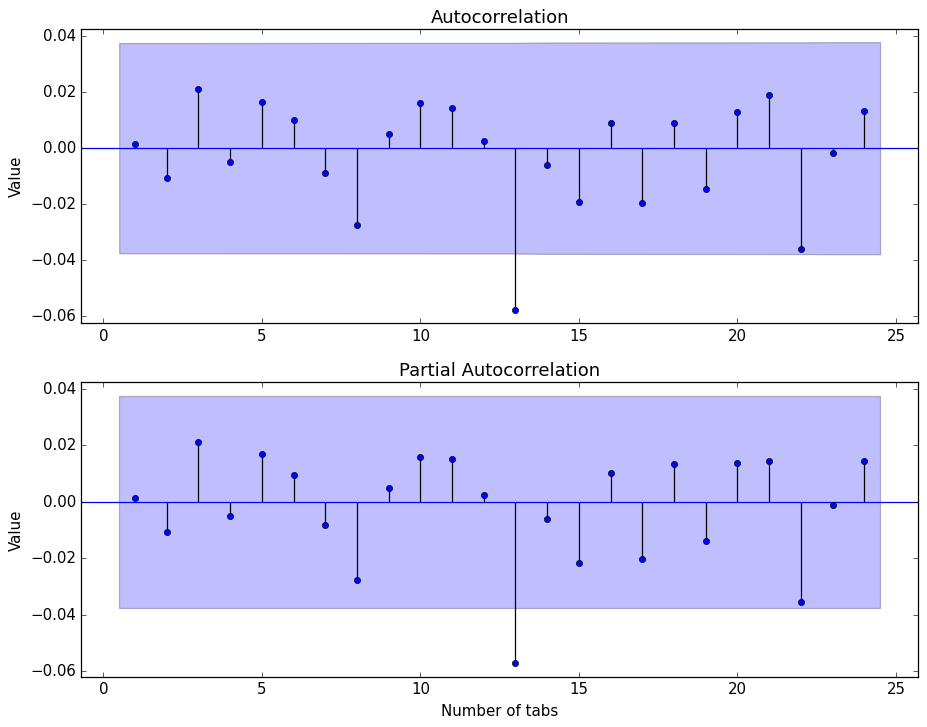

                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 2717
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6668.054
Date:                Thu, 04 Nov 2021   AIC                         -13330.108
Time:                        20:01:05   BIC                         -13312.388
Sample:                             0   HQIC                        -13323.702
                               - 2717                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2768      0.133      2.079      0.038       0.016       0.538
ma.L1         -0.1464      0.137     -1.066      0.286      -0.416       0.123
sigma2         0.0004    3.5e-06    123.173      0.0

2.7159613358862242

4.52473071657285

step: 0.2583956258123751


2.7159613358862242
2.974356961698599
3.232752587510974
3.491148213323349
3.749543839135724
4.007939464948099
4.2663350907604745
4.524730716572849
4.7831263423852235


[2.72, 2.97, 3.23, 3.49, 3.75, 4.01, 4.27, 4.52, 4.78]

2.7159613358862242

4.52473071657285

15.11913765743077

92.27107541149164

step: 11.021705393437268


15.11913765743077
26.140843050868035
37.1625484443053
48.18425383774257
59.20595923117983
70.22766462461709
81.24937001805436
92.27107541149164


[15.12, 26.14, 37.16, 48.18, 59.21, 70.23, 81.25, 92.27]

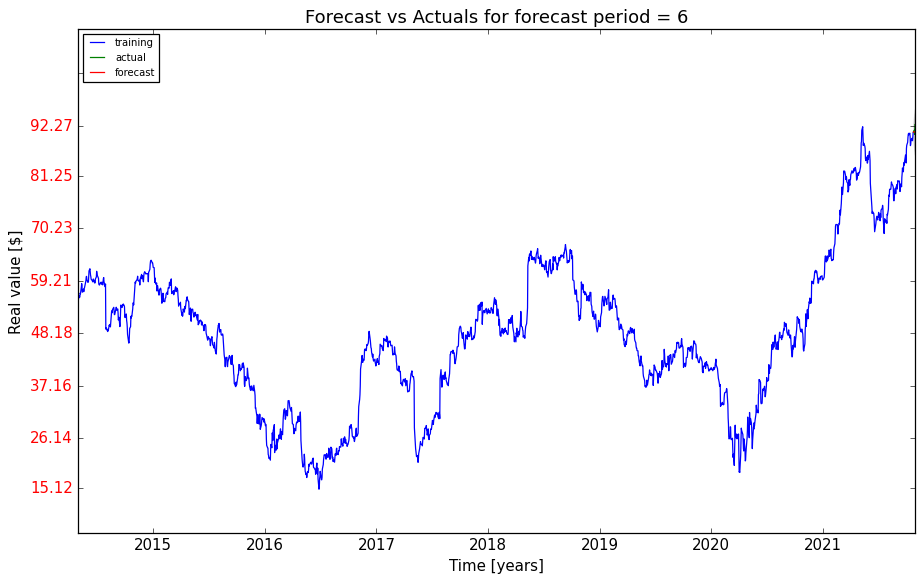

min value 4.374822360936651 max value 4.602281125722497
min value 4.37 max value 4.6
step: 0.03




'final y list'

[4.37, 4.4, 4.43, 4.46, 4.49, 4.52, 4.55, 4.58, 4.61]

min value 4.374822360936651 max value 4.602281125722497
min exp value 79.43 max exp value 99.71
step: 3.38




'final y exp list'

[79.43, 82.81, 86.19, 89.57, 92.95, 96.33]

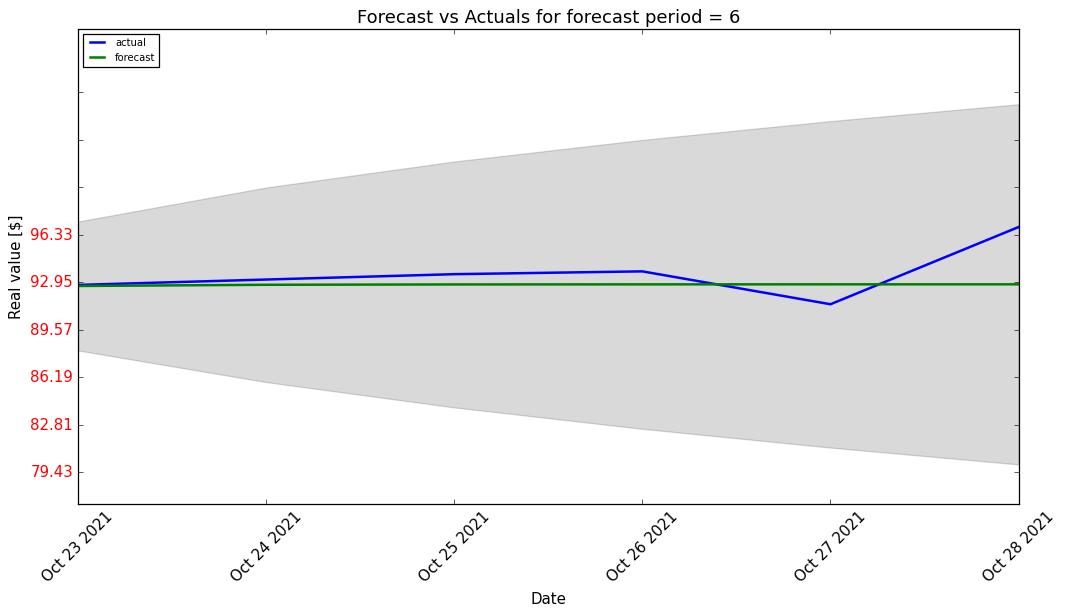

   Company         ARIMA  p  d  q fc_period       MAE
0      ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1      ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2      ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3      ACN  ARIMA(1,1,1)  1  1  1         6  0.039016
4      ACN  ARIMA(1,1,1)  1  1  1        10  0.030514
5      ACN  ARIMA(1,1,1)  1  1  1        30  0.021813
6     AMZN  ARIMA(2,1,1)  2  1  1         6  0.044057
7     AMZN  ARIMA(2,1,1)  2  1  1        10  0.027846
8     AMZN  ARIMA(2,1,1)  2  1  1        30  0.076412
9     AMZN  ARIMA(0,1,2)  0  1  2         6  0.044044
10    AMZN  ARIMA(0,1,2)  0  1  2        10  0.027765
11    AMZN  ARIMA(0,1,2)  0  1  2        30  0.076329
12    ARCB  ARIMA(1,1,1)  1  1  1         6  0.011238
                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 2713
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6657.212
Date:  

2.7159613358862242

4.52473071657285

step: 0.2583956258123751


2.7159613358862242
2.974356961698599
3.232752587510974
3.491148213323349
3.749543839135724
4.007939464948099
4.2663350907604745
4.524730716572849
4.7831263423852235


[2.72, 2.97, 3.23, 3.49, 3.75, 4.01, 4.27, 4.52, 4.78]

2.7159613358862242

4.52473071657285

15.11913765743077

92.27107541149164

step: 11.021705393437268


15.11913765743077
26.140843050868035
37.1625484443053
48.18425383774257
59.20595923117983
70.22766462461709
81.24937001805436
92.27107541149164


[15.12, 26.14, 37.16, 48.18, 59.21, 70.23, 81.25, 92.27]

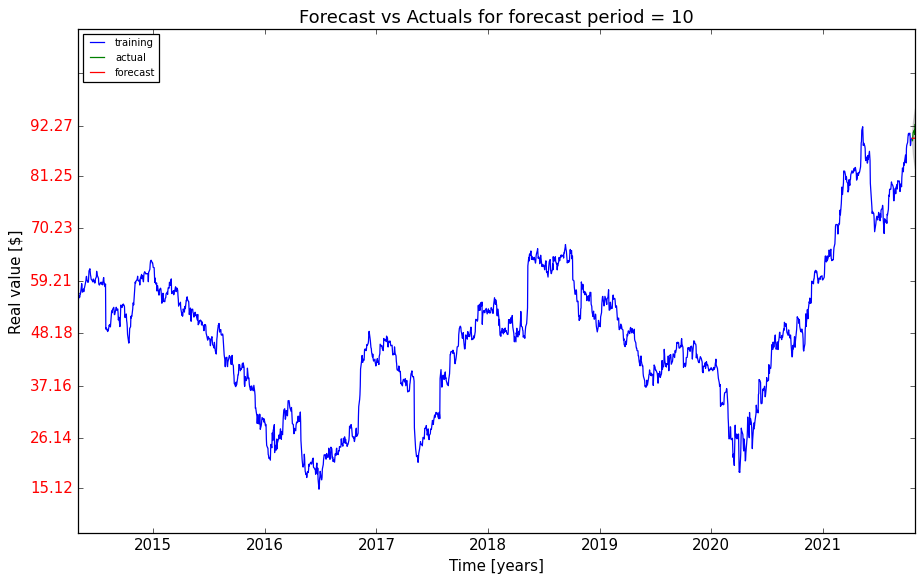

min value 4.30796383843701 max value 4.6058747416208465
min value 4.31 max value 4.61
step: 0.04




'final y list'

[4.31, 4.35, 4.39, 4.43, 4.47, 4.51, 4.55, 4.59, 4.63]

min value 4.30796383843701 max value 4.6058747416208465
min exp value 74.29 max exp value 100.07
step: 4.3




'final y exp list'

[74.29, 78.59, 82.89, 87.19, 91.49, 95.79]

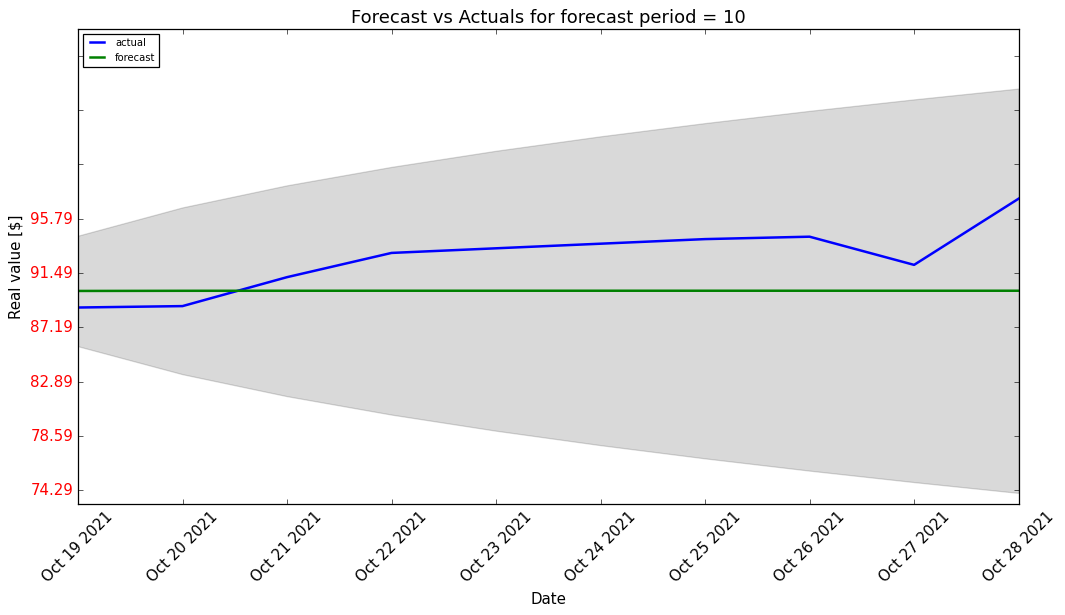

   Company         ARIMA  p  d  q fc_period       MAE
0      ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1      ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2      ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3      ACN  ARIMA(1,1,1)  1  1  1         6  0.039016
4      ACN  ARIMA(1,1,1)  1  1  1        10  0.030514
5      ACN  ARIMA(1,1,1)  1  1  1        30  0.021813
6     AMZN  ARIMA(2,1,1)  2  1  1         6  0.044057
7     AMZN  ARIMA(2,1,1)  2  1  1        10  0.027846
8     AMZN  ARIMA(2,1,1)  2  1  1        30  0.076412
9     AMZN  ARIMA(0,1,2)  0  1  2         6  0.044044
10    AMZN  ARIMA(0,1,2)  0  1  2        10  0.027765
11    AMZN  ARIMA(0,1,2)  0  1  2        30  0.076329
12    ARCB  ARIMA(1,1,1)  1  1  1         6  0.011238
13    ARCB  ARIMA(1,1,1)  1  1  1        10  0.029198
                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 2693
Model:                 ARIMA(1, 

2.7159613358862242

4.52473071657285

step: 0.2583956258123751


2.7159613358862242
2.974356961698599
3.232752587510974
3.491148213323349
3.749543839135724
4.007939464948099
4.2663350907604745
4.524730716572849
4.7831263423852235


[2.72, 2.97, 3.23, 3.49, 3.75, 4.01, 4.27, 4.52, 4.78]

2.7159613358862242

4.52473071657285

15.11913765743077

92.27107541149164

step: 11.021705393437268


15.11913765743077
26.140843050868035
37.1625484443053
48.18425383774257
59.20595923117983
70.22766462461709
81.24937001805436
92.27107541149164


[15.12, 26.14, 37.16, 48.18, 59.21, 70.23, 81.25, 92.27]

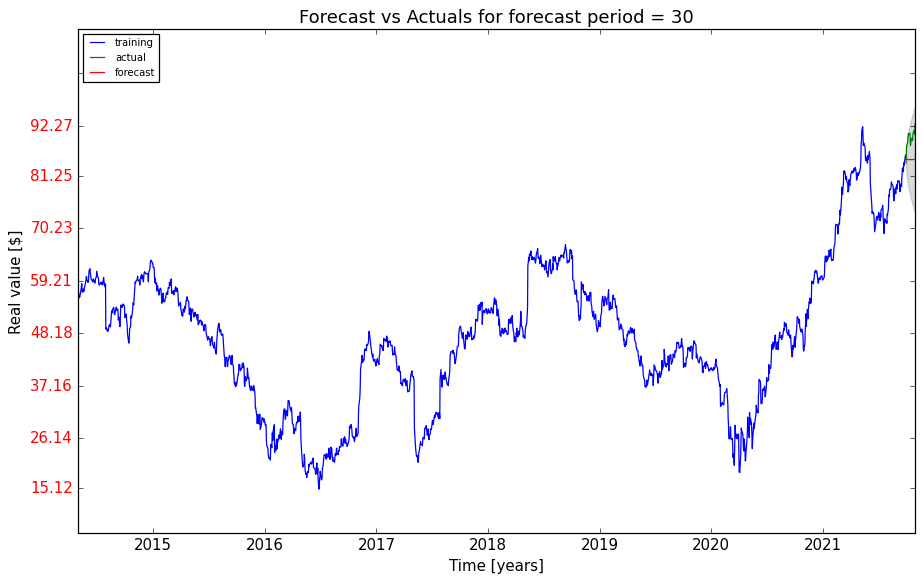

min value 4.088824650279131 max value 4.613485270166237
min value 4.09 max value 4.61
step: 0.07




'final y list'

[4.09, 4.16, 4.23, 4.3, 4.37, 4.44, 4.51, 4.58, 4.65]

min value 4.088824650279131 max value 4.613485270166237
min exp value 59.67 max exp value 100.83
step: 6.86




'final y exp list'

[59.67, 66.53, 73.39, 80.25, 87.11, 93.97]

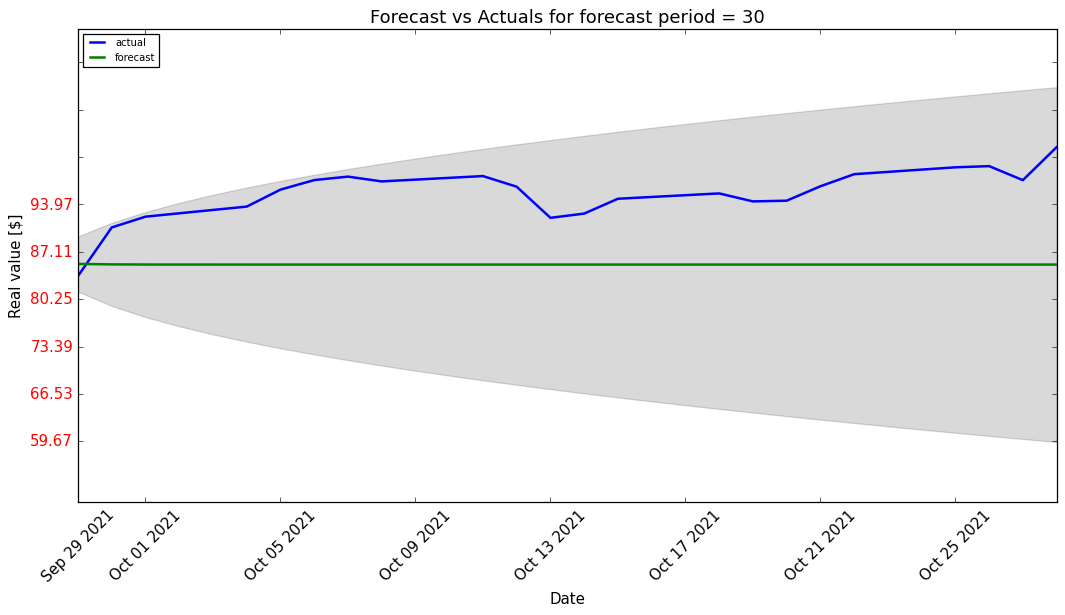

   Company         ARIMA  p  d  q fc_period       MAE
0      ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1      ACN  ARIMA(2,1,1)  2  1  1        10  0.030693
2      ACN  ARIMA(2,1,1)  2  1  1        30  0.021863
3      ACN  ARIMA(1,1,1)  1  1  1         6  0.039016
4      ACN  ARIMA(1,1,1)  1  1  1        10  0.030514
5      ACN  ARIMA(1,1,1)  1  1  1        30  0.021813
6     AMZN  ARIMA(2,1,1)  2  1  1         6  0.044057
7     AMZN  ARIMA(2,1,1)  2  1  1        10  0.027846
8     AMZN  ARIMA(2,1,1)  2  1  1        30  0.076412
9     AMZN  ARIMA(0,1,2)  0  1  2         6  0.044044
10    AMZN  ARIMA(0,1,2)  0  1  2        10  0.027765
11    AMZN  ARIMA(0,1,2)  0  1  2        30  0.076329
12    ARCB  ARIMA(1,1,1)  1  1  1         6  0.011238
13    ARCB  ARIMA(1,1,1)  1  1  1        10  0.029198
14    ARCB  ARIMA(1,1,1)  1  1  1        30  0.107537
counter 3
   Company         ARIMA  p  d  q fc_period       MAE
0      ACN  ARIMA(2,1,1)  2  1  1         6  0.039067
1      ACN  ARIMA(

In [20]:
mae_df = pd.DataFrame(columns = COLUMN_NAMES)
tmp_counter = 0
for path in PREPROCESSED_DATA_PATHS: 
    #SET PLOTS STYLE
    plt.style.use('fivethirtyeight')
    plt.style.use('seaborn-bright')
    #extract company name for further plots
    splitted = path.split("\\")[-1]
    company = splitted.split(".csv")[0]
    print(company)
    df = pd.read_csv(path, index_col=0)
    df.timestamp = pd.to_datetime(df.timestamp)
    df.sort_values(by='timestamp', inplace=True)
    display(df)
    
    #1. Time Series decomposition
    decompose_time_series(df.copy(), company, PERIOD)
    
    #2. Logarithm of company
    if USE_LOG:
        df.avg_price = np.log(df.avg_price)    
    visualize_after_log(df)
    display(df)
        
    #3. Stationarity
    test_statistic, critical_value = perform_df_test(df.avg_price, REGRESSION_TYPE_FOR_DF_TEST, AUTOLAG_FOR_DF_TEST, P_VALUE_PERCENT)
    print(test_statistic, critical_value)
    number_of_first_diff = 0
    if test_statistic > critical_value:
        while(test_statistic > critical_value):
            number_of_first_diff += 1
            df_diff = perform_first_difference(df.copy(), number_of_first_diff)
            test_statistic, critical_value = perform_df_test(df_diff.diff_price, REGRESSION_TYPE_FOR_DF_TEST, AUTOLAG_FOR_DF_TEST, P_VALUE_PERCENT)
            print(f"Number of first diff = {number_of_first_diff}")
            print(test_statistic, critical_value)
            if number_of_first_diff > 2:
                print(f"WARNING! SOMETHING IS WRONG - THERE WAS {number_of_first_diff} first difference")
    else:
        #if no first diff performed - we still need df_diff for further computations
        df_diff = df.copy()
        df_diff = df_diff.rename(columns={'avg_price': 'diff_price'})
    print(f"Number of performed first diff = {number_of_first_diff}")
    display('Original dataframe', df)
    display('First differenced dataframe', df_diff)
    
    #EXTRA STEP: SAVE ACF and PACF chart
    """
    They are used to choose p, q paramaters: usually we count up to 10th tab, how many of them is above the significance level. 
    They are also used to check stationarity: if the tabs come down quickly, then this suggests that the series should be stationary.
    """
    create_acf_pacf_charts(df_diff.diff_price, LJUNGBOX_BOXPIERCE_LAGS, 'timeseries')
    
    #4. Automatically choose ARIMA parameters p, d, q
    """
    IMPORTANT!! I PERFORM ARIMA ON DIFFERENCED AND LOGGED VALUES!!
    Only log values was not enough (not stationary).
    """
    d = number_of_first_diff
    p_range = P_RANGE #range(0, 10)
    q_range = Q_RANGE #range(0, 10)
    #POSSIBLE ARIMA COMBINATIONS - ANALIZA AUTOMATYCZNA
    arima_combinations_list = []
    aic_results_list = []
    bic_results_list = []
    p_parameter_list = []
    d_parameter_list = []
    q_parameter_list = []
    #hqic_results_list = []
    for p in p_range:
        for q in q_range:
            results = ARIMA(df_diff.diff_price, order=(p, d, q), enforce_stationarity=False).fit() #method='innovations_mle'; disp=-1
            #df_diff.diff_price, initialization='approximate_diffuse'
            #, enforce_stationarity=False should help
            #https://github.com/statsmodels/statsmodels/issues/5459
            arima_combinations_list.append(f"ARIMA({p},{d},{q})")
            p_parameter_list.append(p)
            d_parameter_list.append(d)
            q_parameter_list.append(q)
            aic_results_list.append(results.aic)
            bic_results_list.append(results.bic)
            #hqic_results_list.append(results.hqic)            
    print(aic_results_list)
    print(bic_results_list)
    #print(hqic_results_list)
    auto_ARIMA_df = pd.DataFrame(list(zip(arima_combinations_list, 
                                          p_parameter_list, 
                                          d_parameter_list,
                                          q_parameter_list,
                                          aic_results_list, 
                                          bic_results_list)), 
                             columns=['ARIMA', 'p', 'd', 'q', 'AIC', 'BIC'])
    display(auto_ARIMA_df)
    #Save model results to CSV
    auto_ARIMA_df.to_csv(ARIMA_MODEL_RESULTS + '/{0}_ARIMA_parameters.csv'.format(company))
    
    print('Best ARIMA according to AIC criterium:')
    best_ARIMA_aic = auto_ARIMA_df.sort_values(by=['AIC']).iloc[0]
    print(best_ARIMA_aic)
    p_best_aic = best_ARIMA_aic[1]
    q_best_aic = best_ARIMA_aic[3]
    
    print('\nBest ARIMA according to BIC criterium:')
    best_ARIMA_bic = auto_ARIMA_df.sort_values(by=['BIC']).iloc[0]
    print(best_ARIMA_bic)
    p_best_bic = best_ARIMA_bic[1]
    q_best_bic = best_ARIMA_bic[3]
    
    best_pq_list = []
    best_pq_list.append((p_best_aic, q_best_aic))
    if ((p_best_aic, q_best_aic) != (p_best_bic, q_best_bic)):
        best_pq_list.append((p_best_bic, q_best_bic))

    #5. Check the autocorrelations for residuals (white noise)
    for pq in best_pq_list:
        lb_p_value, bp_p_value, residuals = perform_ljungbox_boxpierce(df.avg_price, int(pq[0]), d, int(pq[1]), LJUNGBOX_BOXPIERCE_LAGS)
        create_acf_pacf_charts(residuals, LJUNGBOX_BOXPIERCE_LAGS, 'residuals')
        if (P_VALUE > lb_p_value) or (P_VALUE > bp_p_value):
            img = mpimg.imread(ARIMA_PLOTS + '/{0}_{1}_plot_ACF_and_PACF.png'.format(company, 'residuals'), format='png')
            # Output Images
            fig = plt.figure(figsize=(18,12), dpi=140)
            plt.axis('off') #turn off axis
            plt.title(f'Please decide, if the residuals are white noise.\n \
                When you are ready, close the window and choose. \n \
                Llungbox p_value = {round(lb_p_value, 4)}, Boxpierce p_value = {round(bp_p_value, 4)}. \n \
                Chosen p_value level is {P_VALUE}')
            plt.imshow(img)
            plt.show()
            #USER HAS TO CHOOSE, IF THE SERIES IS STATIONARY
            #TODO: implement tkinter, when this will be a python script
            answer = input('Do the residuals approximate white noise? [y/n]: ') 
            if answer == 'n':
                print('IT IS NOT POSSIBLE TO PERFORM THE FORECAST!\n')
                print('THE MODEL IS ABANDONED!\n')
                #TODO: implement some info ebout this to log file
                continue #this will end this for loop iteration
        #The residuals of the model are white noise. We can proceed.

        #6. PERFORM ARIMA FORECAST
        for period in PERIODS_TO_FORECAST:
            #Prepare train and test set
            #df.index = df.timestamp
            #Używamy wartości tylko po logarytmie, żeby inwestor miał prawdziwe wartości (exp(log_value))
            train = df.avg_price[:-period]
            test = df.avg_price[-period:]
            test_timestamp = df.timestamp[-period:]
            train_timestamp = df.timestamp[:-period]

            #Train the model
            model = ARIMA(train, order=(pq[0], d, pq[1])) 
            fitted = model.fit()
            #print model summary
            print(fitted.summary())
            #save summary to file
            _path = ARIMA_MODEL_RESULTS + f'/{company}_ARIMA({pq[0]},{d},{pq[1]})_model_summary_period_{period}.csv'
            with open(_path, 'w') as f:
                f.write(fitted.summary().as_csv())

            #Test the model (perform forecast)
            #https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html
            fcast_res = fitted.get_forecast(period, alpha=P_VALUE)  # 3 okresy do przodu, 95% conf
            fc = fcast_res.summary_frame()['mean']
            se = fcast_res.summary_frame()['mean_se']
            lower_series = fcast_res.summary_frame()['mean_ci_lower']
            upper_series = fcast_res.summary_frame()['mean_ci_upper']
            #get_forecast instead of forecast
            #se - błąd standardowy, standard error
            #fc - forecast
            #conf - poziom ufności, confidence interval
            # Make as pandas series - NOT NEEDED ANY MORE
            #fc_series = pd.Series(fc, index=test.index)
            #lower_series = pd.Series(conf[:, 0], index=test.index)
            #upper_series = pd.Series(conf[:, 1], index=test.index)           

            #Make plots
            create_prediction_plot(df, train, test, fc, lower_series, upper_series, period, train_timestamp, test_timestamp)
            create_zoomed_prediction_plot(df, test, fc, lower_series, upper_series, period, test_timestamp)
            #Calculate MAE
            mae = np.mean(np.abs(fc.values - test.values))

            #7. SAVE RESULTS
            #7.1 results of specific experiment
            forecast_results = pd.DataFrame(zip(test.values, fc.values), columns=['True_Value', 'ARIMA_forecast'])
            forecast_results['Company'] = 'ACN'
            forecast_results.to_csv(ARIMA_MODEL_RESULTS + f'/{company}_forecast_results_ARIMA({pq[0]},{d},{pq[1]})_period_{period}.csv')
            #7.2 MASTER TABLE
            #[company, ARIMA, p,d,q , period, mae]
            arima_tmp = f'ARIMA({pq[0]},{d},{pq[1]})'
            mae_list = [company, arima_tmp, pq[0], d, pq[1], period, mae] 
            mae_df = mae_df.append(pd.Series(mae_list, index = mae_df.columns), ignore_index=True)
            print(mae_df)
        
    tmp_counter += 1
    print("counter", tmp_counter)
    if tmp_counter == 3:
        break
#7.3 After all experiments
saving_time = datetime.now().strftime('%Y-%m-%d_%H_%M')
mae_df.to_csv(ARIMA_MODEL_RESULTS + f'/MASTER_TABLE_forecast_results_{saving_time}.csv')
print(mae_df)

In [43]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              avg_price   No. Observations:                 2693
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6609.328
Date:                Fri, 05 Nov 2021   AIC                         -13212.656
Time:                        00:07:02   BIC                         -13194.962
Sample:                             0   HQIC                        -13206.256
                               - 2693                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2985      0.132      2.258      0.024       0.039       0.558
ma.L1         -0.1687      0.137     -1.235      0.217      -0.437       0.099
sigma2         0.0004   3.51e-06    122.850      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       38.46   Jarque-Bera (JB):             51713.46
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [3]:
from scipy import linalg
print(linalg.lapack.dgetrf([np.nan]))
print(linalg.lapack.dgetrf([np.inf]))

(array([nan]), array([0], dtype=int32), 0)
(array([inf]), array([0], dtype=int32), 0)


### TK inter

In [ ]:
def ExitApplication():
    MsgBox = tk.messagebox.askquestion('Exit Application', 'Are you sure you want to exit the application', icon = 'warning')
    if MsgBox == 'yes':
        root.destroy()
    else:
        tk.messagebox.showinfo('Return','You will now return to the application screen')

In [ ]:
#from tkinter import * as tk
import tkinter as tk
root = tk.Tk()

In [ ]:
import tkinter as tk
from tkinter import messagebox
import tkinter as tk
root = tk.Tk()

canvas1 = tk.Canvas(root, width = 300, height = 300)
canvas1.pack()

button1 = tk.Button(root, text='Exit Application', command=ExitApplication, bg='brown', fg='white') 
canvas1.create_window(150, 150, window=button1)